__Igor J. M. Marques__

Final Project for the module "Masterclass in Business Analytics" - Queen Mary University of London

*Bibliography:*

1. Géron, A., 2019. Hands-On Machine Learning with Scikit-Learn, Keras & TensorFlow. 2nd ed. Sebastopol: O'Reilly Media.

2. Ebays Used Car Dataset - source: https://www.kaggle.com/orgesleka/used-cars-database/

3. https://www.kaggle.com/fegadeharish/used-cars-price-prediction-with-eda


## 1. FRAMING THE PROBLEM

## Initialization

In [1]:
# Python ≥3.5 is required
import sys
assert sys.version_info >= (3, 5)

# Scikit-Learn ≥0.20 is required
import sklearn
assert sklearn.__version__ >= "0.20"

# Tensorflow and Keras
import tensorflow as tf
from tensorflow import keras
print(tf.__version__)
print(keras.__version__)

import pandas as pd
import datetime as dt
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import os
import statsmodels.api as sm
from scipy import stats

# Packages
from datetime import datetime
from pandas.plotting import scatter_matrix
from matplotlib.cbook import boxplot_stats 
from sklearn.model_selection import StratifiedShuffleSplit
from sklearn.model_selection import train_test_split
from sklearn.base import BaseEstimator, TransformerMixin, RegressorMixin
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import OneHotEncoder
from sklearn.impute import SimpleImputer
from sklearn.pipeline import FeatureUnion
from sklearn.preprocessing import StandardScaler
from sklearn.compose import ColumnTransformer
from keras.layers.advanced_activations import LeakyReLU
from scipy.stats import reciprocal


# Models
from sklearn.tree import DecisionTreeRegressor, DecisionTreeClassifier
from sklearn.ensemble import RandomForestRegressor
from sklearn.svm import LinearSVR
from sklearn.svm import SVR
from sklearn.linear_model import LinearRegression

# Model evaluation und visualisation
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import cross_val_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import roc_curve
from sklearn.metrics import precision_recall_curve

# Hyperparameter optimisation
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import RandomizedSearchCV

# to make this notebook's output stable across runs
np.random.seed(24)

2.1.0
2.2.4-tf


Using TensorFlow backend.


## 2. GETTING THE DATA

In [2]:
#Loading autos.csv file
autos = pd.read_csv("autos.csv", encoding="ISO-8859–1")

In [3]:
#pd.set_option('display.max_rows', 10)

## 3. CLEANING & MANIPULATING THE DATA

### Handling Missing Values and Initial Data Exploration

In [4]:
print(autos.shape)

(371528, 20)


In [5]:
autos.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 371528 entries, 0 to 371527
Data columns (total 20 columns):
 #   Column               Non-Null Count   Dtype 
---  ------               --------------   ----- 
 0   dateCrawled          371528 non-null  object
 1   name                 371528 non-null  object
 2   seller               371528 non-null  object
 3   offerType            371528 non-null  object
 4   price                371528 non-null  int64 
 5   abtest               371528 non-null  object
 6   vehicleType          333659 non-null  object
 7   yearOfRegistration   371528 non-null  int64 
 8   gearbox              351319 non-null  object
 9   powerPS              371528 non-null  int64 
 10  model                351044 non-null  object
 11  kilometer            371528 non-null  int64 
 12  monthOfRegistration  371528 non-null  int64 
 13  fuelType             338142 non-null  object
 14  brand                371528 non-null  object
 15  notRepairedDamage    299468 non-nu

In [6]:
autos.isna().sum()

dateCrawled                0
name                       0
seller                     0
offerType                  0
price                      0
abtest                     0
vehicleType            37869
yearOfRegistration         0
gearbox                20209
powerPS                    0
model                  20484
kilometer                  0
monthOfRegistration        0
fuelType               33386
brand                      0
notRepairedDamage      72060
dateCreated                0
nrOfPictures               0
postalCode                 0
lastSeen                   0
dtype: int64

We can notice that the fields "vehicleType, gearbox, model, fuelType, and notRepairedDamage" have a huge amount of missing values. These will have to be dealth with accordingly.

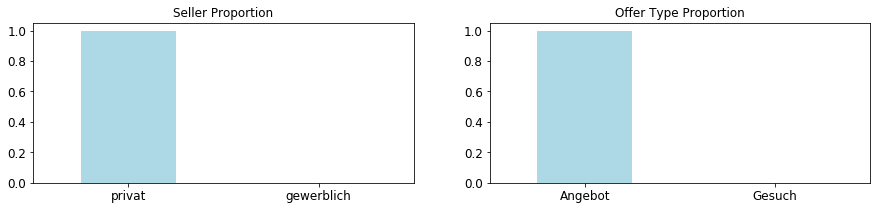

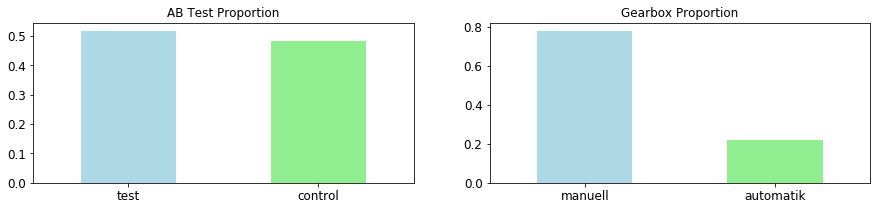

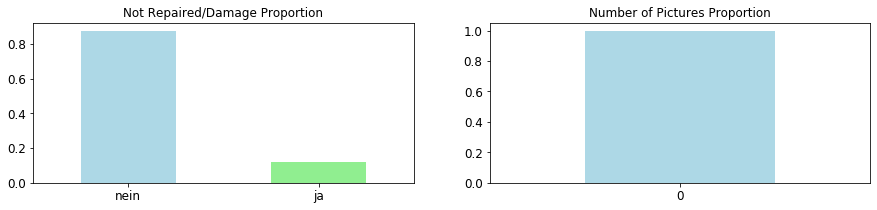

In [7]:
#Seller Proportion
plt.subplots(figsize=(15,10))
plt.subplot(321) #3-digit integer describing the position of the subplot (nrows, ncols, and index)
autos["seller"].value_counts(100).plot(kind='bar', title="Seller Proportion", 
                                       fontsize=18, color=('lightblue', 'lightgreen'))
plt.xticks(rotation=0, fontsize=12)
plt.yticks(rotation=0, fontsize=12)

#Seller Proportion
plt.subplot(322) 
autos["offerType"].value_counts(100).plot(kind='bar', title="Offer Type Proportion", 
                                          fontsize=18, color=('lightblue', 'lightgreen'))
plt.xticks(rotation=0, fontsize=12)
plt.yticks(rotation=0, fontsize=12)
plt.show()

#AB Test Proportion
plt.subplots(figsize=(15,10))
plt.subplot(323) 
autos["abtest"].value_counts(100).plot(kind='bar', title="AB Test Proportion", 
                                       fontsize=18, color=('lightblue', 'lightgreen'))
plt.xticks(rotation=0, fontsize=12)
plt.yticks(rotation=0, fontsize=12)

#Gearbox Proportion
plt.subplot(324) 
autos["gearbox"].value_counts(100).plot(kind='bar', title="Gearbox Proportion", 
                                        fontsize=18, color=('lightblue', 'lightgreen'))
plt.xticks(rotation=0, fontsize=12)
plt.yticks(rotation=0, fontsize=12)
plt.show()

#Not Repaired/Damage Proportion
plt.subplots(figsize=(15,10))
plt.subplot(325) 
autos["notRepairedDamage"].value_counts(100).plot(kind='bar', title="Not Repaired/Damage Proportion", 
                                       fontsize=18, color=('lightblue', 'lightgreen'))
plt.xticks(rotation=0, fontsize=12)
plt.yticks(rotation=0, fontsize=12)

#Number of Pictures Proportion
plt.subplot(326) 
autos["nrOfPictures"].value_counts(100).plot(kind='bar', title="Number of Pictures Proportion", 
                                        fontsize=18, color=('lightblue', 'lightgreen'))
plt.xticks(rotation=0, fontsize=12)
plt.yticks(rotation=0, fontsize=12)
plt.show()


From the graphs above, we can notice that Seller, Offer Type, and Number of Pictures are not relevant as 99.99% of the data have the same input, thus it won't have any effect in the model. Hence, these three features will be removed. However, before dropping the whole column, we need to remove the rows corresponding to 'gewerblich' and 'Gesuch'. In addition, the features "name", "abtest", "monthOfRegistration" and "postalCode" do not seem to add any value to the model, thus it will be removed.

In [8]:
autos.drop(autos[autos['seller'] == 'gewerblich'].index, inplace=True)
autos.drop(autos[autos['offerType'] == 'Gesuch'].index, inplace=True)

In [9]:
autos_1 = autos.drop(["name", "seller", "offerType", "abtest", "monthOfRegistration", "nrOfPictures", "postalCode"], axis=1)

In [10]:
autos_1.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 371513 entries, 0 to 371527
Data columns (total 13 columns):
 #   Column              Non-Null Count   Dtype 
---  ------              --------------   ----- 
 0   dateCrawled         371513 non-null  object
 1   price               371513 non-null  int64 
 2   vehicleType         333651 non-null  object
 3   yearOfRegistration  371513 non-null  int64 
 4   gearbox             351310 non-null  object
 5   powerPS             371513 non-null  int64 
 6   model               351032 non-null  object
 7   kilometer           371513 non-null  int64 
 8   fuelType            338134 non-null  object
 9   brand               371513 non-null  object
 10  notRepairedDamage   299460 non-null  object
 11  dateCreated         371513 non-null  object
 12  lastSeen            371513 non-null  object
dtypes: int64(4), object(9)
memory usage: 39.7+ MB


We wish to add an extra variable to our dataset, which is __"number of days it took to sell the car"__, as we believe it could pontentially have an effect in our future models. In order to do so, we will first convert __lastSeen__ and __dataCreated__ to datetime format, then we will subtract one from another to get number of days.

In [11]:
autos_1.loc[:,"lastSeen"] = pd.to_datetime(autos_1.loc[:,"lastSeen"])
autos_1.loc[:,"dateCreated"] = pd.to_datetime(autos_1.loc[:,"dateCreated"])
autos_1.loc[:,"numberOfDaysToSell"]=autos_1.loc[:,"lastSeen"]-autos_1.loc[:,"dateCreated"]

In [12]:
autos_1.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 371513 entries, 0 to 371527
Data columns (total 14 columns):
 #   Column              Non-Null Count   Dtype          
---  ------              --------------   -----          
 0   dateCrawled         371513 non-null  object         
 1   price               371513 non-null  int64          
 2   vehicleType         333651 non-null  object         
 3   yearOfRegistration  371513 non-null  int64          
 4   gearbox             351310 non-null  object         
 5   powerPS             371513 non-null  int64          
 6   model               351032 non-null  object         
 7   kilometer           371513 non-null  int64          
 8   fuelType            338134 non-null  object         
 9   brand               371513 non-null  object         
 10  notRepairedDamage   299460 non-null  object         
 11  dateCreated         371513 non-null  datetime64[ns] 
 12  lastSeen            371513 non-null  datetime64[ns] 
 13  numberOfDaysTo

In [13]:
autos_1.head()

,dateCrawled,price,vehicleType,yearOfRegistration,gearbox,powerPS,model,kilometer,fuelType,brand,notRepairedDamage,dateCreated,lastSeen,numberOfDaysToSell
0,2016-03-24 11:52:17,480,NaN,1993,manuell,0,golf,150000,benzin,volkswagen,NaN,2016-03-24,2016-04-07 03:16:57,14 days 03:16:57
1,2016-03-24 10:58:45,18300,coupe,2011,manuell,190,NaN,125000,diesel,audi,ja,2016-03-24,2016-04-07 01:46:50,14 days 01:46:50
2,2016-03-14 12:52:21,9800,suv,2004,automatik,163,grand,125000,diesel,jeep,NaN,2016-03-14,2016-04-05 12:47:46,22 days 12:47:46
3,2016-03-17 16:54:04,1500,kleinwagen,2001,manuell,75,golf,150000,benzin,volkswagen,nein,2016-03-17,2016-03-17 17:40:17,0 days 17:40:17
4,2016-03-31 17:25:20,3600,kleinwagen,2008,manuell,69,fabia,90000,diesel,skoda,nein,2016-03-31,2016-04-06 10:17:21,6 days 10:17:21


The column "numberOfDaysToSell" was created, however the variable is in a timedelta format. We wish to convert the values in it into a _float type,_ representing the number of days in a numerical form.

In [14]:
autos_1['numberOfDaysToSell'] = (autos_1['numberOfDaysToSell'].dt.total_seconds())/86400

In [15]:
autos_1.head()

,dateCrawled,price,vehicleType,yearOfRegistration,gearbox,powerPS,model,kilometer,fuelType,brand,notRepairedDamage,dateCreated,lastSeen,numberOfDaysToSell
0,2016-03-24 11:52:17,480,NaN,1993,manuell,0,golf,150000,benzin,volkswagen,NaN,2016-03-24,2016-04-07 03:16:57,14.136771
1,2016-03-24 10:58:45,18300,coupe,2011,manuell,190,NaN,125000,diesel,audi,ja,2016-03-24,2016-04-07 01:46:50,14.074190
2,2016-03-14 12:52:21,9800,suv,2004,automatik,163,grand,125000,diesel,jeep,NaN,2016-03-14,2016-04-05 12:47:46,22.533171
3,2016-03-17 16:54:04,1500,kleinwagen,2001,manuell,75,golf,150000,benzin,volkswagen,nein,2016-03-17,2016-03-17 17:40:17,0.736308
4,2016-03-31 17:25:20,3600,kleinwagen,2008,manuell,69,fabia,90000,diesel,skoda,nein,2016-03-31,2016-04-06 10:17:21,6.428715


Now that the variable __"numberOfDaysToSell"__ has been created, we can delete the columns dateCrawled, dataCreated, lastSeen, as they are no longer needed.

In [16]:
autos_2 = autos_1.drop(["dateCrawled", "dateCreated", "lastSeen"], axis=1)

In [17]:
autos_2.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 371513 entries, 0 to 371527
Data columns (total 11 columns):
 #   Column              Non-Null Count   Dtype  
---  ------              --------------   -----  
 0   price               371513 non-null  int64  
 1   vehicleType         333651 non-null  object 
 2   yearOfRegistration  371513 non-null  int64  
 3   gearbox             351310 non-null  object 
 4   powerPS             371513 non-null  int64  
 5   model               351032 non-null  object 
 6   kilometer           371513 non-null  int64  
 7   fuelType            338134 non-null  object 
 8   brand               371513 non-null  object 
 9   notRepairedDamage   299460 non-null  object 
 10  numberOfDaysToSell  371513 non-null  float64
dtypes: float64(1), int64(4), object(6)
memory usage: 34.0+ MB


In [18]:
autos_2.head()

,price,vehicleType,yearOfRegistration,gearbox,powerPS,model,kilometer,fuelType,brand,notRepairedDamage,numberOfDaysToSell
0,480,NaN,1993,manuell,0,golf,150000,benzin,volkswagen,NaN,14.136771
1,18300,coupe,2011,manuell,190,NaN,125000,diesel,audi,ja,14.074190
2,9800,suv,2004,automatik,163,grand,125000,diesel,jeep,NaN,22.533171
3,1500,kleinwagen,2001,manuell,75,golf,150000,benzin,volkswagen,nein,0.736308
4,3600,kleinwagen,2008,manuell,69,fabia,90000,diesel,skoda,nein,6.428715


In [19]:
#The describe() method shows a summary of the numerical attributes
autos_2.describe().round(2)

,price,yearOfRegistration,powerPS,kilometer,numberOfDaysToSell
count,3.715130e+05,371513.00,371513.00,371513.00,371513.00
mean,1.729570e+04,2004.58,115.55,125619.71,9.33
std,3.588026e+06,92.87,192.14,40110.83,8.66
min,0.000000e+00,1000.00,0.00,5000.00,0.02
25%,1.150000e+03,1999.00,70.00,125000.00,2.56
50%,2.950000e+03,2003.00,105.00,150000.00,6.53
75%,7.200000e+03,2008.00,150.00,150000.00,14.09
max,2.147484e+09,9999.00,20000.00,150000.00,759.20


A quick way to get a feel of the data type is to plot a histogram for each numerical attribute.

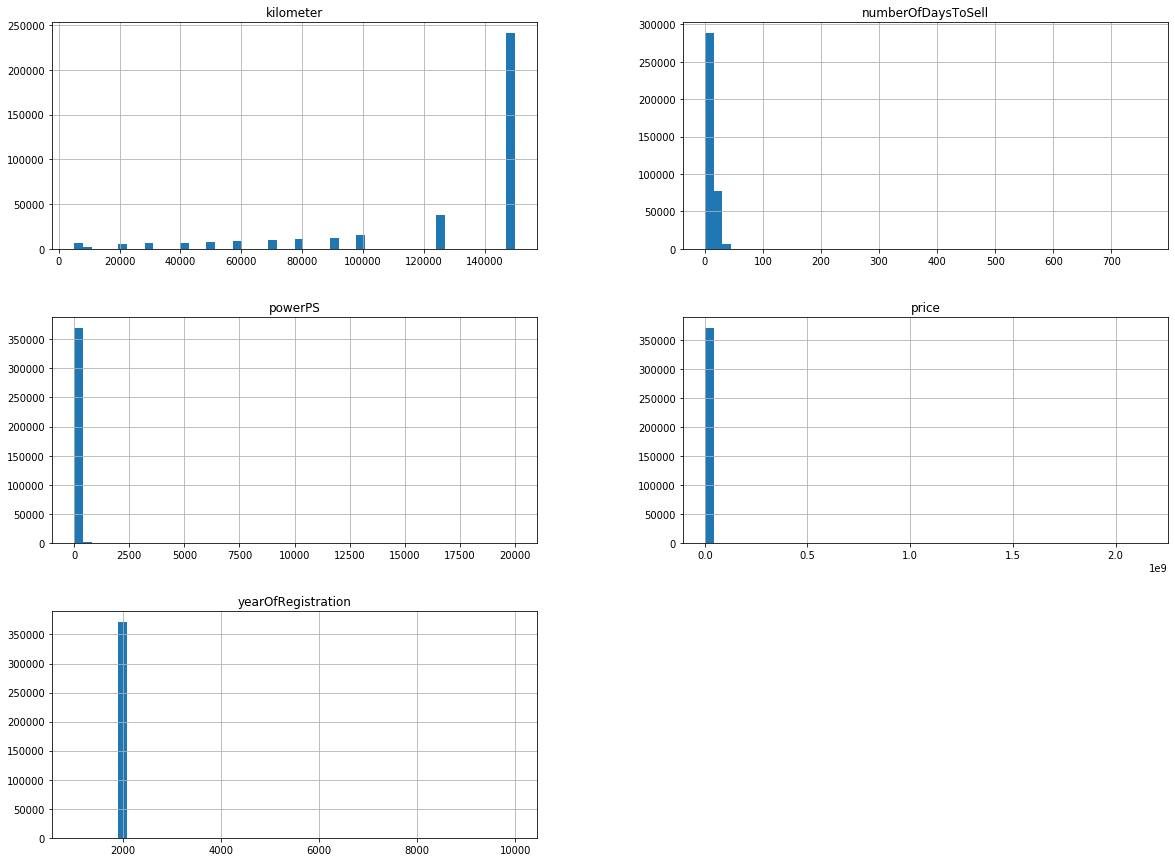

In [20]:
autos_2.hist(bins=50, figsize=(20,15))
plt.show()

From the initial analysis above we can notice the following:

* Number of days to sell is extremely skewed to the right
* Power PS is extremely skewed to the right
* Price is extremely skewed to the right
* Year of is extremely skewed to the right

Hence further investigations are necessary, as the skewness might be due to user typos. A boxplot chart might be helpful.

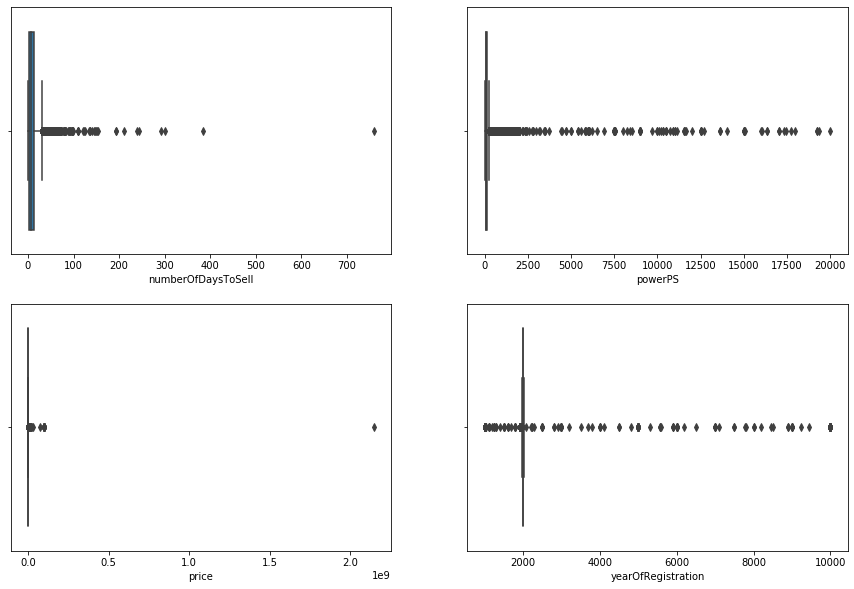

In [21]:
plt.subplots(figsize=(15,10))
sns.load_dataset("tips")

# Distribution of the "numberOfDaysToSell" variable
plt.subplot(221)
sns.boxplot(autos_2["numberOfDaysToSell"])

# Distribution of the "powerPS" variable
plt.subplot(222)
sns.boxplot(autos_2["powerPS"])

# Distribution of the "price" variable
plt.subplot(223)
sns.boxplot(autos_2["price"])

# Distribution of the "yearOfRegistration" variable
plt.subplot(224)
sns.boxplot(autos_2['yearOfRegistration'])

plt.show()

From the boxplots above we can notice really extreme outliers which are surely masking the real distribution of the data. These outliers will have to be removed. Using quantiles, let's understand first how much is the proportion of these outliers to the rest of the data.

In [22]:
quantile = np.quantile(a=autos_2["numberOfDaysToSell"], q=[0.05,0.1,0.25,0.5,0.75,0.99,0.995,0.9999,0.99999,1])
q_values=[0.05,0.1,0.25,0.5,0.75,0.99,0.995,0.9999,0.99999,1]
n=0
for q in quantile:
    print("Quantile", '({})'.format(q_values[n]), '{:.2f}'.format(q))
    n = n + 1

Quantile (0.05) 0.57
Quantile (0.1) 0.78
Quantile (0.25) 2.56
Quantile (0.5) 6.53
Quantile (0.75) 14.09
Quantile (0.99) 31.49
Quantile (0.995) 32.40
Quantile (0.9999) 87.35
Quantile (0.99999) 258.16
Quantile (1) 759.20


In [23]:
quantile = np.quantile(a=autos_2["powerPS"], q=[0.1,0.12,0.15,0.25,0.5,0.75,0.99,0.995,0.9999,0.99999,1])
q_values=[0.1,0.12,0.15,0.25,0.5,0.75,0.99,0.995,0.9999,0.99999,1]
n=0
for q in quantile:
    print("Quantile", '({})'.format(q_values[n]), '{:.2f}'.format(q))
    n = n + 1

Quantile (0.1) 0.00
Quantile (0.12) 45.00
Quantile (0.15) 54.00
Quantile (0.25) 70.00
Quantile (0.5) 105.00
Quantile (0.75) 150.00
Quantile (0.99) 340.00
Quantile (0.995) 404.00
Quantile (0.9999) 10879.76
Quantile (0.99999) 18295.51
Quantile (1) 20000.00


In [24]:
quantile = np.quantile(a=autos_2["price"], q=[0.03,0.04,0.1,0.25,0.5,0.75,0.99,0.995,0.9999,0.99999,1])
q_values=[0.03,0.04,0.1,0.25,0.5,0.75,0.99,0.995,0.9999,0.99999,1]
n=0
for q in quantile:
    print("Quantile", '({})'.format(q_values[n]), '{:.2f}'.format(q))
    n = n + 1

Quantile (0.03) 1.00
Quantile (0.04) 140.00
Quantile (0.1) 500.00
Quantile (0.25) 1150.00
Quantile (0.5) 2950.00
Quantile (0.75) 7200.00
Quantile (0.99) 36000.00
Quantile (0.995) 47500.00
Quantile (0.9999) 11111111.00
Quantile (0.99999) 99999999.00
Quantile (1) 2147483647.00


In [25]:
quantile = np.quantile(a=autos_2["yearOfRegistration"], q=[0.05,0.1,0.25,0.5,0.75,0.99,0.995,0.9999,0.99999,1])
q_values=[0.05,0.1,0.25,0.5,0.75,0.99,0.995,0.9999,0.99999,1]
n=0
for q in quantile:
    print("Quantile", '({})'.format(q_values[n]), '{:.2f}'.format(q))
    n = n + 1

Quantile (0.05) 1992.00
Quantile (0.1) 1995.00
Quantile (0.25) 1999.00
Quantile (0.5) 2003.00
Quantile (0.75) 2008.00
Quantile (0.99) 2018.00
Quantile (0.995) 2018.00
Quantile (0.9999) 8493.20
Quantile (0.99999) 9999.00
Quantile (1) 9999.00


__Findings of the analysis__:

* The 99.5th percentile of the variable "numberOfDaysToSell" is 32.40
* The 10th percentile of the variable "powerPS" is 0 (most likely to be user typos)
* The 99.5th percentile of the variable "powerPS" is 404
* The 3rd percentile of the variable "price" is 1 (most likely to be errors or old cars)
* The 99.5th percentile of the variable "price" is 47500
* The 10th percentile of the variable "yearOfRegistration" is 1995 (really old cars)
* The 99.5th percentile of the variable "yearOfRegistration" is 2018


We can also notice a considerable amount of data 

The data below the 10th percentile, as well as the data beyond the 95th percentile is very likely to be noise or input error from the user. Thus, we will delete it to prevent it from biasing the models.

The selected ranges for each variable are as follows:

* numberOfDaysToSell = from 0 to 32.4
* powerPS = from 45 to 404
* price = from 100 to 47,500
* yearOfRegistration = from 1990 to 2018

In [26]:
autos_3 = autos_2.copy()
autos_3 = autos_3[(autos_3["numberOfDaysToSell"] <= 32.4)]
autos_3 = autos_3[(autos_3["powerPS"] >= 45) & (autos_3["powerPS"] <= 404)]
autos_3 = autos_3[(autos_3["price"] >= 100) & (autos_3["price"] <= 47500)]
autos_3 = autos_3[(autos_3["yearOfRegistration"] >= 1990) & (autos_3["yearOfRegistration"] <= 2018)]

In [27]:
autos_3.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 308742 entries, 1 to 371527
Data columns (total 11 columns):
 #   Column              Non-Null Count   Dtype  
---  ------              --------------   -----  
 0   price               308742 non-null  int64  
 1   vehicleType         288035 non-null  object 
 2   yearOfRegistration  308742 non-null  int64  
 3   gearbox             303118 non-null  object 
 4   powerPS             308742 non-null  int64  
 5   model               297348 non-null  object 
 6   kilometer           308742 non-null  int64  
 7   fuelType            289844 non-null  object 
 8   brand               308742 non-null  object 
 9   notRepairedDamage   263724 non-null  object 
 10  numberOfDaysToSell  308742 non-null  float64
dtypes: float64(1), int64(4), object(6)
memory usage: 28.3+ MB


In [28]:
autos_3.describe()

,price,yearOfRegistration,powerPS,kilometer,numberOfDaysToSell
count,308742.000000,308742.000000,308742.000000,308742.000000,308742.000000
mean,5813.357088,2004.162586,124.814577,126388.667561,9.323005
std,6574.030800,6.089257,56.016697,38494.237812,8.238715
min,100.000000,1990.000000,45.000000,5000.000000,0.017778
25%,1400.000000,2000.000000,80.000000,125000.000000,2.622616
50%,3400.000000,2004.000000,116.000000,150000.000000,6.595741
75%,7800.000000,2008.000000,150.000000,150000.000000,14.114777
max,47500.000000,2018.000000,404.000000,150000.000000,32.387326


Let's have a look at the variables' distribution after the outliers removal step.

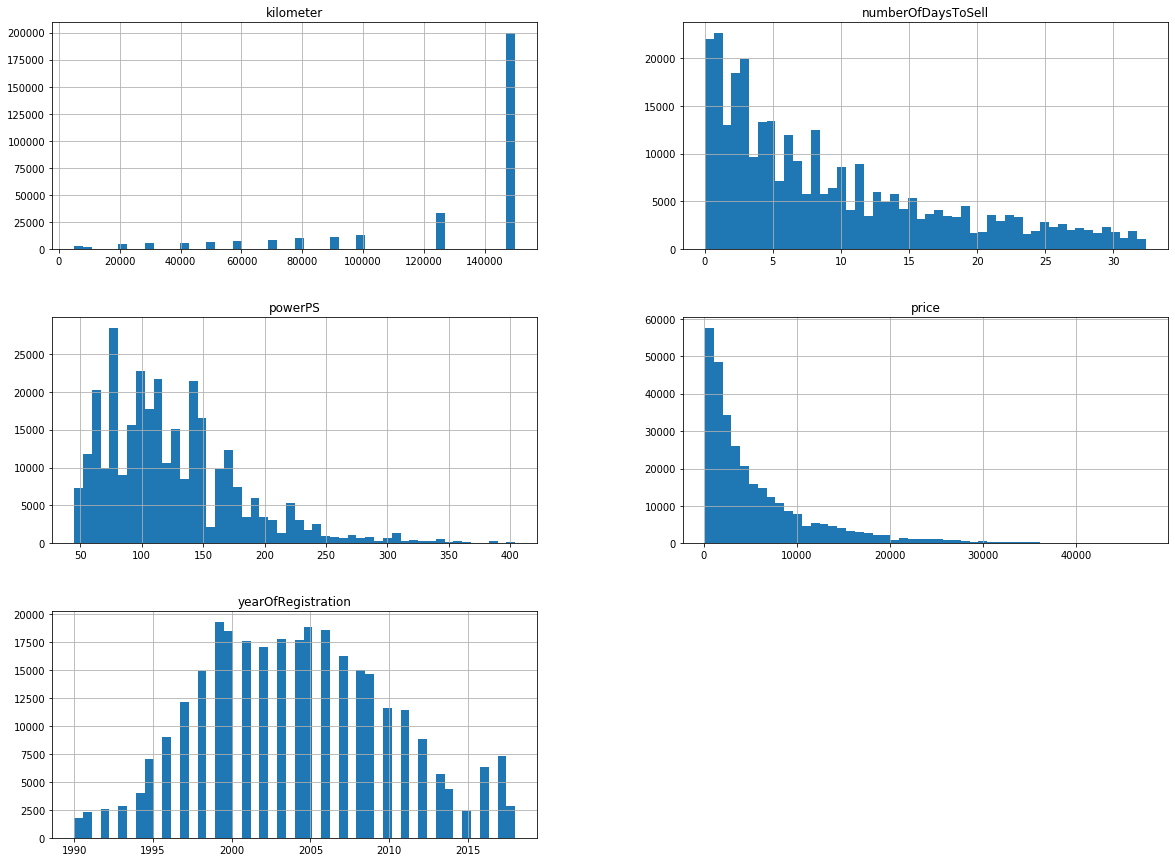

In [29]:
autos_3.hist(bins=50, figsize=(20,15))
plt.show()

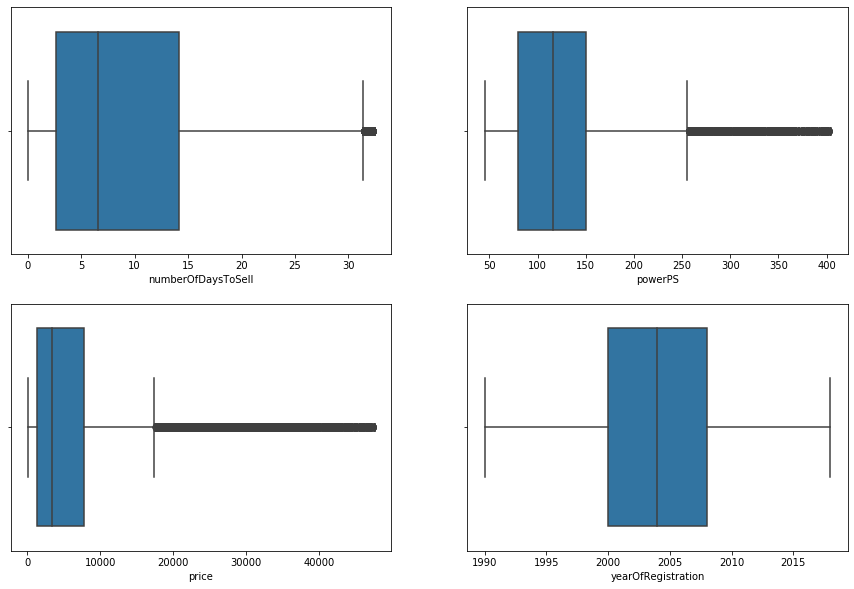

In [30]:
plt.subplots(figsize=(15,10))
sns.load_dataset("tips")

# Distribution of the "numberOfDaysToSell" variable
plt.subplot(221)
sns.boxplot(autos_3["numberOfDaysToSell"])

# Distribution of the "powerPS" variable
plt.subplot(222)
sns.boxplot(autos_3["powerPS"])

# Distribution of the "price" variable
plt.subplot(223)
sns.boxplot(autos_3["price"])

# Distribution of the "yearOfRegistration" variable
plt.subplot(224)
sns.boxplot(autos_3['yearOfRegistration'])

plt.show()

According to the dataset, the last car ad created on Ebay was on 7-Apr-2016, thus the yearOfRegistration beyond 2016 is likely to be an incorrect information. Let's replace the year of registration based on the car mileage (kilometer).

In [31]:
np.sort(autos_3['yearOfRegistration'].unique())

array([1990, 1991, 1992, 1993, 1994, 1995, 1996, 1997, 1998, 1999, 2000,
       2001, 2002, 2003, 2004, 2005, 2006, 2007, 2008, 2009, 2010, 2011,
       2012, 2013, 2014, 2015, 2016, 2017, 2018], dtype=int64)

In [32]:
kilometer_v = np.sort(autos_3['kilometer'].unique())
print(kilometer_v)
year_v = [2016,2017,2018]
print(year_v)

[  5000  10000  20000  30000  40000  50000  60000  70000  80000  90000
 100000 125000 150000]
[2016, 2017, 2018]


In [33]:
(autos_3["yearOfRegistration"]>=2016).value_counts()

False    292186
True      16556
Name: yearOfRegistration, dtype: int64

In [34]:
for y in year_v:
    n = 2015
    for k in kilometer_v:
        autos_3['yearOfRegistration'] = np.where((autos_3['yearOfRegistration'] == y) 
                                               & (autos_3['kilometer'] == k), n, autos_3['yearOfRegistration'])
        n = n - 1    

In [35]:
autos_3.describe()

,price,yearOfRegistration,powerPS,kilometer,numberOfDaysToSell
count,308742.000000,308742.000000,308742.000000,308742.000000,308742.000000
mean,5813.357088,2003.484447,124.814577,126388.667561,9.323005
std,6574.030800,5.333421,56.016697,38494.237812,8.238715
min,100.000000,1990.000000,45.000000,5000.000000,0.017778
25%,1400.000000,2000.000000,80.000000,125000.000000,2.622616
50%,3400.000000,2003.000000,116.000000,150000.000000,6.595741
75%,7800.000000,2007.000000,150.000000,150000.000000,14.114777
max,47500.000000,2015.000000,404.000000,150000.000000,32.387326


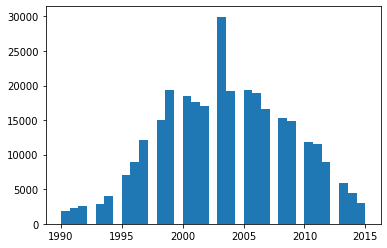

In [36]:
plt.hist(autos_3['yearOfRegistration'], bins = 35)
plt.show()

In [37]:
autos_3.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 308742 entries, 1 to 371527
Data columns (total 11 columns):
 #   Column              Non-Null Count   Dtype  
---  ------              --------------   -----  
 0   price               308742 non-null  int64  
 1   vehicleType         288035 non-null  object 
 2   yearOfRegistration  308742 non-null  int64  
 3   gearbox             303118 non-null  object 
 4   powerPS             308742 non-null  int64  
 5   model               297348 non-null  object 
 6   kilometer           308742 non-null  int64  
 7   fuelType            289844 non-null  object 
 8   brand               308742 non-null  object 
 9   notRepairedDamage   263724 non-null  object 
 10  numberOfDaysToSell  308742 non-null  float64
dtypes: float64(1), int64(4), object(6)
memory usage: 28.3+ MB


Having completed our inital data cleaning and exploration, the next step will be to handle the missing values.

In [38]:
autos_4 = autos_3.copy()
autos_4.isna().sum()

price                     0
vehicleType           20707
yearOfRegistration        0
gearbox                5624
powerPS                   0
model                 11394
kilometer                 0
fuelType              18898
brand                     0
notRepairedDamage     45018
numberOfDaysToSell        0
dtype: int64

In [39]:
autos_4["notRepairedDamage"].value_counts()

nein    235310
ja       28414
Name: notRepairedDamage, dtype: int64

The attribute "notRepairedDamage is easy to fill in the blanks with the Max Frequency value "nein", as nearly 90% of the observations occur as "nein".
The method ffill will be used. This function is used to fill the missing value in the dataframe. ‘ffill’ stands for ‘forward fill’ and will propagate last valid observation forward.

In [40]:
autos_4["notRepairedDamage"] = autos_4["notRepairedDamage"].fillna(method='ffill')

In [41]:
autos_4["notRepairedDamage"].isna().sum()

0

To impute the missing values of the other categorical variables, we will use the prediction values of Decision Tree Classifiers. There are stil 4 attributes to treat: "vehicleType", "gearbox", "model", and "fuelType".

In [42]:
# VehicleType attribute

# Filtering data for model building
X = autos_4[autos_4['vehicleType'].notna()].drop(['vehicleType', 'model'], axis=1)
y = autos_4['vehicleType'][autos_4['vehicleType'].notna()]

# Creating a test data with uknown vehicleType attributes
xt = autos_4[autos_4['vehicleType'].isna()].drop(['vehicleType', 'model'], axis=1)

# One-hot encoding 
X_dum = pd.get_dummies(X)
xt_dum = pd.get_dummies(xt)

# Building the decision tree classifier
dtc_vt = DecisionTreeClassifier().fit(X_dum, y)

# Predicting null values
y_pred = dtc_vt.predict(xt_dum)
print(np.unique(y_pred, return_counts=True))

# Filling the missing values with the predicted values
autos_4.loc[(autos_4['vehicleType'].isna()),'vehicleType'] = y_pred
autos_4['vehicleType'].isna().sum()

(array(['andere', 'bus', 'cabrio', 'coupe', 'kleinwagen', 'kombi',
       'limousine', 'suv'], dtype=object), array([ 325, 2058,  735,  983, 6831, 4098, 5190,  487], dtype=int64))


0

In [43]:
# Model attribute

# Filtering data for model building
X = autos_4[autos_4['model'].notna()].drop('model', axis=1)
y = autos_4['model'][autos_4['model'].notna()]

# Creating a test data with uknown vehicleType attributes
xt = autos_4[autos_4['model'].isna()].drop('model', axis=1)

# One-hot encoding 
X_dum = pd.get_dummies(X)
xt_dum = pd.get_dummies(xt)
xt_dum.drop('brand_sonstige_autos', axis=1, inplace=True)

# Building the decision tree classifier
dtc_vt = DecisionTreeClassifier().fit(X_dum, y)

# Predicting null values
y_pred = dtc_vt.predict(xt_dum)
#print(np.unique(y_pred, return_counts=True))

# Filling the missing values with the predicted values
autos_4.loc[(autos_4['model'].isna()),'model'] = y_pred
autos_4['model'].isna().sum()

0

In [44]:
# Gearbox attribute

# Filtering data for model building
X = autos_4[autos_4['gearbox'].notna()].drop('gearbox', axis=1)
y = autos_4['gearbox'][autos_4['gearbox'].notna()]

# Creating a test data with uknown vehicleType attributes
xt = autos_4[autos_4['gearbox'].isna()].drop('gearbox', axis=1)

# One-hot encoding 
X_dum = pd.get_dummies(X)
xt_dum = pd.get_dummies(xt)
for col in X_dum.columns:
    if col not in xt_dum:
        xt_dum[col] = np.zeros(len(xt_dum))

# Building the decision tree classifier
dtc_vt = DecisionTreeClassifier().fit(X_dum, y)

# Predicting null values
y_pred = dtc_vt.predict(xt_dum)
print(np.unique(y_pred, return_counts=True))

# Filling the missing values with the predicted values
autos_4.loc[(autos_4['gearbox'].isna()),'gearbox'] = y_pred
autos_4['gearbox'].isna().sum()

(array(['automatik', 'manuell'], dtype=object), array([1030, 4594], dtype=int64))


0

In [45]:
# Fuel Type attribute

# Filtering data for model building
X = autos_4[autos_4['fuelType'].notna()].drop('fuelType', axis=1)
y = autos_4['fuelType'][autos_4['fuelType'].notna()]

# Creating a test data with uknown vehicleType attributes
xt = autos_4[autos_4['fuelType'].isna()].drop('fuelType', axis=1)

# One-hot encoding 
X_dum = pd.get_dummies(X)
xt_dum = pd.get_dummies(xt)
for col in X_dum.columns:
    if col not in xt_dum:
        xt_dum[col] = np.zeros(len(xt_dum))

# Building the decision tree classifier
dtc_vt = DecisionTreeClassifier().fit(X_dum, y)

# Predicting null values
y_pred = dtc_vt.predict(xt_dum)
print(np.unique(y_pred, return_counts=True))

# Filling the missing values with the predicted values
autos_4.loc[(autos_4['fuelType'].isna()),'fuelType'] = y_pred
autos_4['fuelType'].isna().sum()

(array(['andere', 'benzin', 'cng', 'diesel', 'elektro', 'hybrid', 'lpg'],
      dtype=object), array([    5, 14116,    25,  4314,     6,     5,   427], dtype=int64))


0

Verifying if a null values have been treated:

In [46]:
autos_4.isna().sum()

price                 0
vehicleType           0
yearOfRegistration    0
gearbox               0
powerPS               0
model                 0
kilometer             0
fuelType              0
brand                 0
notRepairedDamage     0
numberOfDaysToSell    0
dtype: int64

In [47]:
autos_4.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 308742 entries, 1 to 371527
Data columns (total 11 columns):
 #   Column              Non-Null Count   Dtype  
---  ------              --------------   -----  
 0   price               308742 non-null  int64  
 1   vehicleType         308742 non-null  object 
 2   yearOfRegistration  308742 non-null  int64  
 3   gearbox             308742 non-null  object 
 4   powerPS             308742 non-null  int64  
 5   model               308742 non-null  object 
 6   kilometer           308742 non-null  int64  
 7   fuelType            308742 non-null  object 
 8   brand               308742 non-null  object 
 9   notRepairedDamage   308742 non-null  object 
 10  numberOfDaysToSell  308742 non-null  float64
dtypes: float64(1), int64(4), object(6)
memory usage: 28.3+ MB


In [49]:
autos = autos_4.copy() #continuation of original code

In [52]:
# Select duplicate rows except first occurrence based on all columns
duplicateRowsAutos = autos[autos.duplicated()]
 
print("Duplicate Rows except first occurrence based on all columns are :")
print(duplicateRowsAutos)

Duplicate Rows except first occurrence based on all columns are :
        price vehicleType  yearOfRegistration    gearbox  powerPS    model  \
30145    6990       kombi                2006  automatik      150  octavia   
79271   10000       kombi                2013    manuell      184     golf   
81255   15700         suv                2011    manuell      189   andere   
81273     800       kombi                1993    manuell       90     golf   
83559    4299       coupe                2000    manuell      193      3er   
...       ...         ...                 ...        ...      ...      ...   
362789  24000       coupe                2009  automatik      354       a5   
363452   1800   limousine                1997    manuell      116      3er   
366966  17999       kombi                2011  automatik      143       a4   
371298   8450       kombi                2007  automatik      140   passat   
371436   6500   limousine                1993  automatik      286      5er  

In [53]:
autos = autos.drop_duplicates(keep='last')

In [54]:
autos.info() #new variable after duplicate rows were deleted

<class 'pandas.core.frame.DataFrame'>
Int64Index: 308607 entries, 1 to 371527
Data columns (total 11 columns):
 #   Column              Non-Null Count   Dtype  
---  ------              --------------   -----  
 0   price               308607 non-null  int64  
 1   vehicleType         308607 non-null  object 
 2   yearOfRegistration  308607 non-null  int64  
 3   gearbox             308607 non-null  object 
 4   powerPS             308607 non-null  int64  
 5   model               308607 non-null  object 
 6   kilometer           308607 non-null  int64  
 7   fuelType            308607 non-null  object 
 8   brand               308607 non-null  object 
 9   notRepairedDamage   308607 non-null  object 
 10  numberOfDaysToSell  308607 non-null  float64
dtypes: float64(1), int64(4), object(6)
memory usage: 28.3+ MB


Categorical variables:
> vehicleType, gearbox, model, fuelType, brand, notRepairedDamage

Numerical variables:
>price, yearOfRegistration, powerPS, kilometer, numberOfDaysToSell

Let's create a list with all the categories names, for further exploration of the categorial values.

In [55]:
autos_cat = ['vehicleType', 'gearbox', 'model', 'fuelType', 'brand', 'notRepairedDamage']
for c in autos_cat:
    print(c, ":")
    print(autos[c].value_counts())

vehicleType :
limousine     88487
kleinwagen    74458
kombi         64590
bus           28964
cabrio        20281
coupe         16021
suv           13277
andere         2529
Name: vehicleType, dtype: int64
gearbox :
manuell      241243
automatik     67364
Name: gearbox, dtype: int64
model :
golf          26746
andere        21227
3er           18877
polo          11310
corsa         10618
              ...  
kalina            9
elefantino        9
i3                7
200               4
serie_2           1
Name: model, Length: 247, dtype: int64
fuelType :
benzin     202293
diesel     100296
lpg          5150
cng           522
hybrid        242
andere         58
elektro        46
Name: fuelType, dtype: int64
brand :
volkswagen        66791
bmw               35061
opel              33069
mercedes_benz     29050
audi              28711
ford              21029
renault           14278
peugeot            9539
fiat               7467
seat               6156
skoda              5127
mazda      

## 4. FURTHER DATA EXPLORATION

We wish to analyze the relationship between "Year of Registration" and "Prices". 

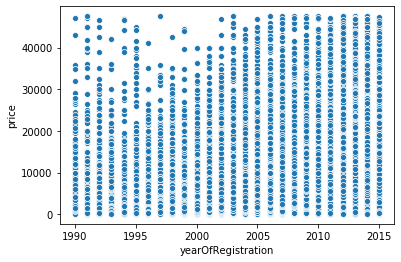

In [56]:
sns.scatterplot(
    x='yearOfRegistration',
    y='price',
    data=autos)

We decided to apply the log function to the feature price to see if we get a more normal distribution.

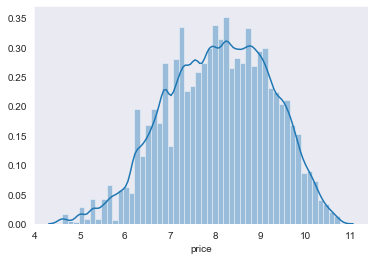

In [57]:
log_price = np.log(autos['price'])
sns.set_style("dark")
sns.distplot(log_price,label="Logarithmic price")

In [58]:
autos.describe().round(2)

,price,yearOfRegistration,powerPS,kilometer,numberOfDaysToSell
count,308607.00,308607.00,308607.00,308607.00,308607.00
mean,5812.97,2003.48,124.81,126390.67,9.32
std,6573.92,5.33,56.02,38494.12,8.24
min,100.00,1990.00,45.00,5000.00,0.02
25%,1400.00,2000.00,80.00,125000.00,2.62
50%,3400.00,2003.00,116.00,150000.00,6.60
75%,7800.00,2007.00,150.00,150000.00,14.11
max,47500.00,2015.00,404.00,150000.00,32.39


We can also use the pandas scatter_matrix() function to check correlation. This function plots every numerical attribute against other numerical attribute. To reduce the amount of plots, let's focus on some few attributes that seem most correlated with median housing value:

In [60]:
corr_matrix = autos.corr()
corr_matrix

,price,yearOfRegistration,powerPS,kilometer,numberOfDaysToSell
price,1.000000,0.651201,0.570415,-0.472492,0.149332
yearOfRegistration,0.651201,1.000000,0.220970,-0.514504,0.089936
powerPS,0.570415,0.220970,1.000000,0.002565,0.078357
kilometer,-0.472492,-0.514504,0.002565,1.000000,-0.086917
numberOfDaysToSell,0.149332,0.089936,0.078357,-0.086917,1.000000


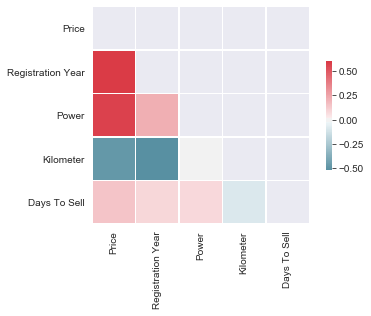

In [61]:
autos_num_corr = autos.copy()
autos_num_corr = autos_num_corr.drop(autos_cat, axis=1)

# Corrplot
corr_matrix = autos_num_corr.corr()

# Generate a mask for the upper triangle
mask = np.triu(np.ones_like(corr_matrix, dtype=np.bool))

# Generate a custom diverging colormap
cmap = sns.diverging_palette(220, 10, as_cmap=True)

# Draw the heatmap with the mask and correct aspect ratio
sns.heatmap(corr_matrix, mask=mask, cmap=cmap, vmax=.6, center=0,
            xticklabels=('Price','Registration Year','Power','Kilometer', 'Days To Sell'),
            yticklabels=('Price','Registration Year','Power','Kilometer', 'Days To Sell'),
            square=True, linewidths=.5, cbar_kws={"shrink": .5})

In [62]:
corr_matrix['price'].sort_values(ascending=False)

price                 1.000000
yearOfRegistration    0.651201
powerPS               0.570415
numberOfDaysToSell    0.149332
kilometer            -0.472492
Name: price, dtype: float64

In [63]:
# get top 10 most frequent names
n = 10
top10 = autos['brand'].value_counts()[:n]

[Text(0, 0.5, 'Frequency'), Text(0.5, 0, 'Brand')]

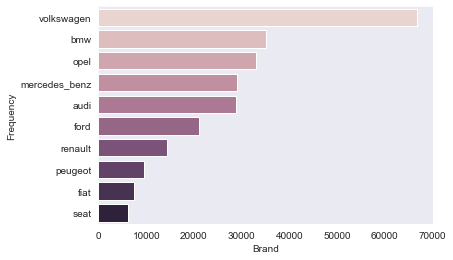

In [64]:
top10brand=sns.countplot(y="brand", data=autos, palette=sns.cubehelix_palette(10),
              order=autos.brand.value_counts().iloc[:10].index)
top10brand.set(xlabel="Brand", ylabel = "Frequency")

In [67]:
price = autos['price'].values
brand = autos['brand'].values

price_tr=[None]*len(autos)
brand_tr=[None]*len(autos)

for i in range(len(autos)):
    if brand[i] in top10.index:
        price_tr[i] = price[i]
        brand_tr[i] = brand[i]

[Text(0, 0.5, 'Price'), Text(0.5, 0, 'Top 10 Brands')]

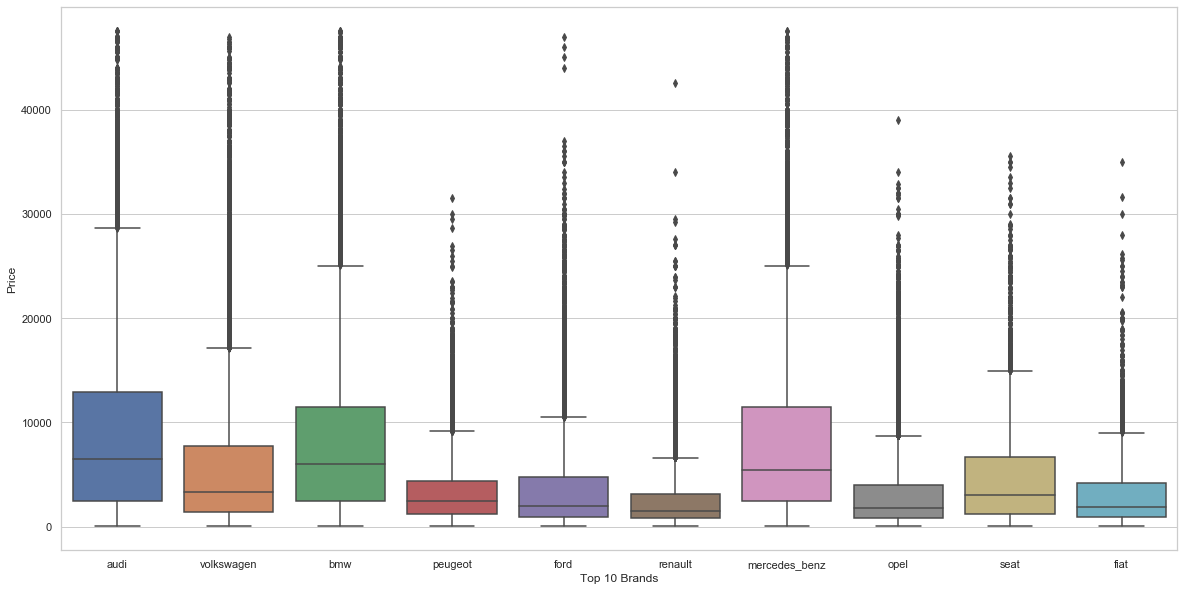

In [68]:
plt.figure(figsize=(20,10))
sns.set(style="whitegrid")
tips = sns.load_dataset("tips")
bxp = sns.boxplot(y=price_tr, x=brand_tr)
bxp.set(ylabel = "Price", xlabel = "Top 10 Brands")

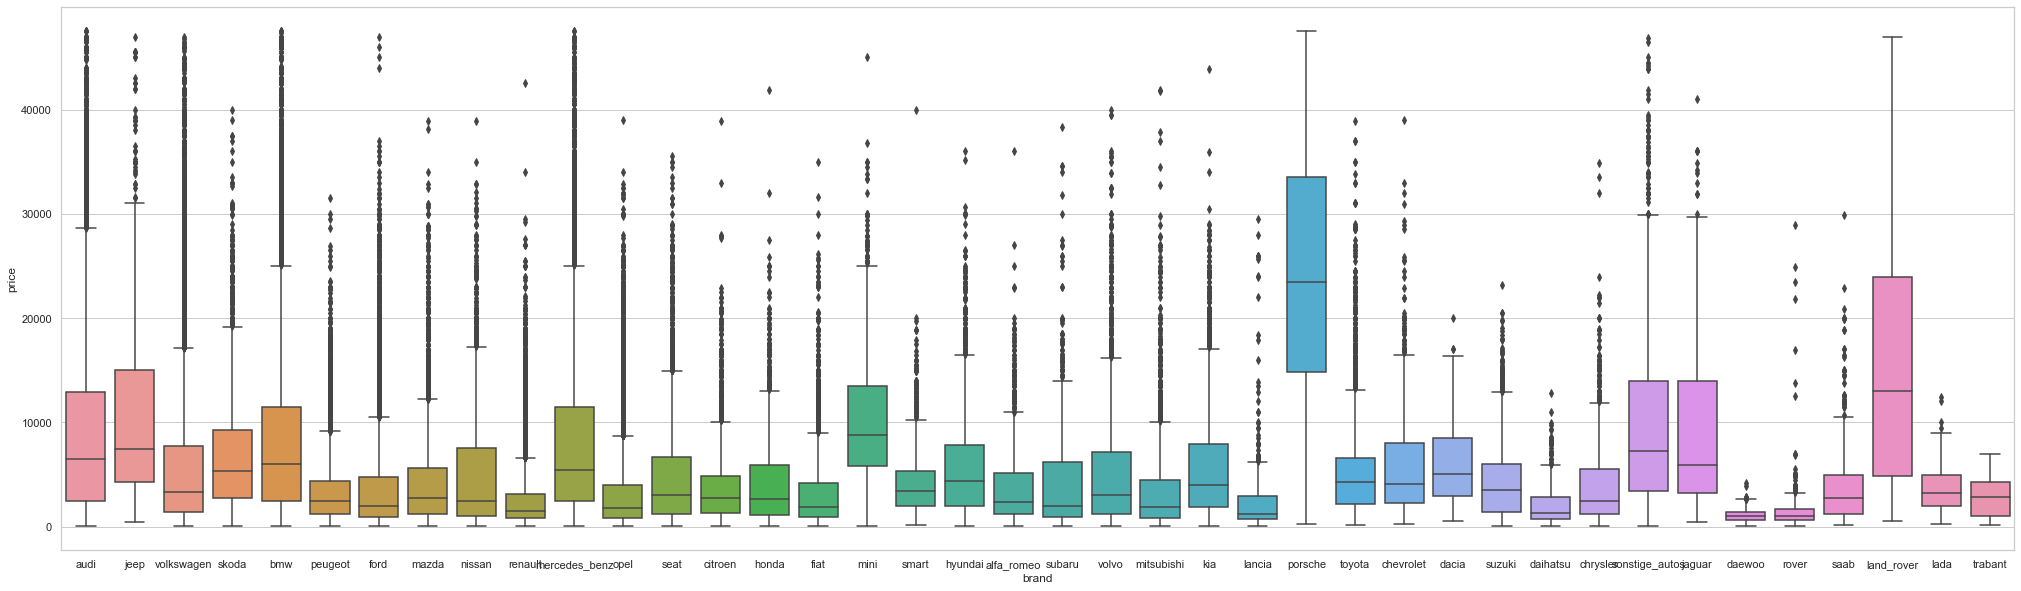

In [69]:
plt.figure(figsize=(35,10))
sns.set(style="whitegrid")
tips = sns.load_dataset("tips")
sns.boxplot(y=autos['price'], x=autos['brand'])

In [73]:
autos.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 308607 entries, 1 to 371527
Data columns (total 11 columns):
 #   Column              Non-Null Count   Dtype  
---  ------              --------------   -----  
 0   price               308607 non-null  int64  
 1   vehicleType         308607 non-null  object 
 2   yearOfRegistration  308607 non-null  int64  
 3   gearbox             308607 non-null  object 
 4   powerPS             308607 non-null  int64  
 5   model               308607 non-null  object 
 6   kilometer           308607 non-null  int64  
 7   fuelType            308607 non-null  object 
 8   brand               308607 non-null  object 
 9   notRepairedDamage   308607 non-null  object 
 10  numberOfDaysToSell  308607 non-null  float64
dtypes: float64(1), int64(4), object(6)
memory usage: 38.3+ MB


## 5. TEST-TRAIN SPLIT

__BUSINESS MODEL 1:__ Considers the __car features__ (model, year, power, fuel type, brand, etc.) as explanatory/independent variables and has __price__ as response/dependent variable.

In [70]:
autos_label_m1 = autos['price'].copy()
autos_features_m1 = autos.drop(['numberOfDaysToSell','price'], axis=1)

autos_features_m1_tr, autos_features_m1_test, autos_label_m1_tr, autos_label_m1_test \
    = train_test_split(autos_features_m1, autos_label_m1, test_size = 0.2, random_state=24)

In [71]:
print(autos_label_m1_tr.shape)
print(autos_label_m1_test.shape)
print(autos_features_m1_tr.shape)
print(autos_features_m1_test.shape)

(246885,)
(61722,)
(246885, 9)
(61722, 9)


In [72]:
autos_features_m1_tr.head()

,vehicleType,yearOfRegistration,gearbox,powerPS,model,kilometer,fuelType,brand,notRepairedDamage
255226,kleinwagen,2012,manuell,60,mii,90000,benzin,seat,nein
103808,coupe,2002,automatik,163,c_klasse,125000,benzin,mercedes_benz,nein
82004,kleinwagen,2014,manuell,69,500,10000,benzin,fiat,nein
130208,limousine,2015,manuell,143,1er,20000,diesel,bmw,nein
165869,kombi,1998,manuell,116,legacy,125000,benzin,subaru,nein


In [74]:
autos_label_m1_tr.head()

255226     5349
103808     5000
82004      8750
130208    21600
165869      449
Name: price, dtype: int64

In [75]:
#final check for missing values:
for i in autos_features_m1_tr:
    print(i, autos[i].isnull().sum() )
for i in autos_features_m1_test:
    print(i, autos[i].isnull().sum() )

vehicleType 0
yearOfRegistration 0
gearbox 0
powerPS 0
model 0
kilometer 0
fuelType 0
brand 0
notRepairedDamage 0
vehicleType 0
yearOfRegistration 0
gearbox 0
powerPS 0
model 0
kilometer 0
fuelType 0
brand 0
notRepairedDamage 0


__BUSINESS MODEL 2:__ Considers the __car features__ (model, year, power, fuel type, brand, etc.) + __price__ as explanatory/independent variables and has __numberOfDaysToSell__ as response/dependent variable.

In [76]:
autos_label_m2 = autos['numberOfDaysToSell'].copy()
autos_features_m2 = autos.drop('numberOfDaysToSell', axis=1)

autos_features_m2_tr, autos_features_m2_test, autos_label_m2_tr, autos_label_m2_test \
    = train_test_split(autos_features_m2, autos_label_m2, test_size = 0.2, random_state=24)

In [77]:
print(autos_label_m2_tr.shape)
print(autos_label_m2_test.shape)
print(autos_features_m2_tr.shape)
print(autos_features_m2_test.shape)

(246885,)
(61722,)
(246885, 10)
(61722, 10)


In [78]:
autos_features_m2_tr.head()

,price,vehicleType,yearOfRegistration,gearbox,powerPS,model,kilometer,fuelType,brand,notRepairedDamage
255226,5349,kleinwagen,2012,manuell,60,mii,90000,benzin,seat,nein
103808,5000,coupe,2002,automatik,163,c_klasse,125000,benzin,mercedes_benz,nein
82004,8750,kleinwagen,2014,manuell,69,500,10000,benzin,fiat,nein
130208,21600,limousine,2015,manuell,143,1er,20000,diesel,bmw,nein
165869,449,kombi,1998,manuell,116,legacy,125000,benzin,subaru,nein


In [79]:
autos_label_m2_tr.head()

255226     4.074421
103808     9.365498
82004     31.929259
130208     2.803009
165869     2.970833
Name: numberOfDaysToSell, dtype: float64

In [80]:
#final check for missing values:
for i in autos_features_m2_tr:
    print(i, autos[i].isnull().sum() )
for i in autos_features_m2_test:
    print(i, autos[i].isnull().sum() )

price 0
vehicleType 0
yearOfRegistration 0
gearbox 0
powerPS 0
model 0
kilometer 0
fuelType 0
brand 0
notRepairedDamage 0
price 0
vehicleType 0
yearOfRegistration 0
gearbox 0
powerPS 0
model 0
kilometer 0
fuelType 0
brand 0
notRepairedDamage 0


## 6. PREPARE THE DATA FOR MACHINE LEARNING ALGORITHMS

### Business Model 1

Numerical and categorical values are treated differently. Thus, let us split the dataset into two subsets: numerical and categorical.

In [81]:
autos_features_m1_tr.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 246885 entries, 255226 to 291334
Data columns (total 9 columns):
 #   Column              Non-Null Count   Dtype 
---  ------              --------------   ----- 
 0   vehicleType         246885 non-null  object
 1   yearOfRegistration  246885 non-null  int64 
 2   gearbox             246885 non-null  object
 3   powerPS             246885 non-null  int64 
 4   model               246885 non-null  object
 5   kilometer           246885 non-null  int64 
 6   fuelType            246885 non-null  object
 7   brand               246885 non-null  object
 8   notRepairedDamage   246885 non-null  object
dtypes: int64(3), object(6)
memory usage: 18.8+ MB


In [82]:
autos_features_m1_tr_num = autos_features_m1_tr.drop(autos_cat, axis=1)
autos_features_m1_tr_num.head()

,yearOfRegistration,powerPS,kilometer
255226,2012,60,90000
103808,2002,163,125000
82004,2014,69,10000
130208,2015,143,20000
165869,1998,116,125000


In [83]:
autos_num = ['yearOfRegistration', 'powerPS', 'kilometer']
autos_features_m1_tr_cat = autos_features_m1_tr.drop(autos_num, axis=1)

In [84]:
autos_features_m1_tr_cat.head()

,vehicleType,gearbox,model,fuelType,brand,notRepairedDamage
255226,kleinwagen,manuell,mii,benzin,seat,nein
103808,coupe,automatik,c_klasse,benzin,mercedes_benz,nein
82004,kleinwagen,manuell,500,benzin,fiat,nein
130208,limousine,manuell,1er,diesel,bmw,nein
165869,kombi,manuell,legacy,benzin,subaru,nein


Next, we create a class to select numerical or categorical columns since Scikit-Learn doesn't handle DataFrames.

In [85]:
class DataFrameSelector(BaseEstimator, TransformerMixin):
    def __init__(self, feature_names):
        self.attribute_names = feature_names
    def fit(self, X, y=None):
        return self
    def transform(self, X):
        return X[self.attribute_names].values

Next, a few data transformations will be carried out. First, __Feature scaling__, which is used to prevent ML algorithms to create bias towards variables with bigger values. We will be using the Standard Scaler transform. The idea behind *StandardScaler()* is that it will transform your data such that its distribution will have a mean value 0 and standard deviation of 1. In case of multivariate data, this is done feature-wise (in other words independently for each column of the data). Given the distribution of the data, each value in the dataset will have the mean value subtracted, and then divided by the standard deviation of the whole dataset (or feature in the multivariate case), __(Géron, 2019)__.

In [86]:
# The imputer is fittet on the training data. It can then also be applied to the test data (without a refit)
num_pipeline = Pipeline([
        ('selector', DataFrameSelector(autos_num)),
        ('std_scaler', StandardScaler())
    ])

# We run the pipeline to check, whether it runs with no problems
temp = num_pipeline.fit_transform(autos_features_m1_tr)

In [87]:
autos_features_m1_tr_num_transf = pd.DataFrame(temp, columns=autos_features_m1_tr_num.columns, index=autos_features_m1_tr_num.index)
autos_features_m1_tr_num_transf.head()

,yearOfRegistration,powerPS,kilometer
255226,1.596569,-1.157859,-0.945993
103808,-0.279371,0.680370,-0.036209
82004,1.971756,-0.997237,-3.025497
130208,2.159350,0.323432,-2.765559
165869,-1.029747,-0.158434,-0.036209


Now we need to create one binary attribute per category. This is called **one-hot encoding**, because only one attribute will be equal to 1 (hot), while the other will be 0 (cold),  __(Géron, 2019)__.

In [88]:
# One-Hot-Encoder replaces categorical features by boolean features, stating wether a certain category is true or not
cat_pipeline = Pipeline([
        ('selector', DataFrameSelector(autos_cat)),
        ('cat_encoder', OneHotEncoder(sparse=False)),
    ])

# We run the pipeline to check, whether it runs with no problems
temp = cat_pipeline.fit_transform(autos_features_m1_tr)

After one-hot encoding, we get a matrix with hundreds of columns, and the matrix is full of 0s except for a single 1 per row. The result is a SciPy sparse matrix that only stores the location of the nonzero element in order to reduce memory usage.

In [89]:
#Combine both imputers and get cleaned data
full_pipeline = FeatureUnion(transformer_list=[
        ("num_pipeline", num_pipeline),
        ("cat_pipeline", cat_pipeline),
    ])
autos_features_prepared_m1_tr = full_pipeline.fit_transform(autos_features_m1_tr)

In [90]:
autos_features_prepared_m1_tr

array([[ 1.5965686 , -1.15785914, -0.94599261, ...,  0.        ,
         0.        ,  1.        ],
       [-0.27937088,  0.68036955, -0.03620929, ...,  0.        ,
         0.        ,  1.        ],
       [ 1.9717565 , -0.99723721, -3.02549733, ...,  0.        ,
         0.        ,  1.        ],
       ...,
       [ 0.28341097, -0.15843383,  0.61363593, ...,  0.        ,
         0.        ,  1.        ],
       [ 0.65859886, -0.89015593, -0.03620929, ...,  0.        ,
         0.        ,  1.        ],
       [ 1.40897465,  1.41209165,  0.61363593, ...,  0.        ,
         0.        ,  1.        ]])

In [91]:
print(autos_features_prepared_m1_tr.shape)
print(autos_label_m1_tr.shape)
print(type(autos_features_prepared_m1_tr))
print(type(autos_label_m1_tr))

(246885, 309)
(246885,)
<class 'numpy.ndarray'>
<class 'pandas.core.series.Series'>


In [92]:
#Converting autos_label_m1_tr and autos_label_m1_test to numpy array
autos_label_m1_tr = autos_label_m1_tr.to_numpy()
autos_label_m1_test = autos_label_m1_test.to_numpy()

In [93]:
type(autos_label_m1_tr)

numpy.ndarray

### Business Model 2

In [94]:
autos_features_m2_tr.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 246885 entries, 255226 to 291334
Data columns (total 10 columns):
 #   Column              Non-Null Count   Dtype 
---  ------              --------------   ----- 
 0   price               246885 non-null  int64 
 1   vehicleType         246885 non-null  object
 2   yearOfRegistration  246885 non-null  int64 
 3   gearbox             246885 non-null  object
 4   powerPS             246885 non-null  int64 
 5   model               246885 non-null  object
 6   kilometer           246885 non-null  int64 
 7   fuelType            246885 non-null  object
 8   brand               246885 non-null  object
 9   notRepairedDamage   246885 non-null  object
dtypes: int64(4), object(6)
memory usage: 20.7+ MB


In [95]:
autos_features_m2_tr_num = autos_features_m2_tr.drop(autos_cat, axis=1)
autos_features_m2_tr_num.head()

,price,yearOfRegistration,powerPS,kilometer
255226,5349,2012,60,90000
103808,5000,2002,163,125000
82004,8750,2014,69,10000
130208,21600,2015,143,20000
165869,449,1998,116,125000


In [96]:
autos_num_2 = ['price','yearOfRegistration', 'powerPS', 'kilometer']
autos_features_m2_tr_cat = autos_features_m2_tr.drop(autos_num_2, axis=1)
autos_features_m2_tr_cat.head()

,vehicleType,gearbox,model,fuelType,brand,notRepairedDamage
255226,kleinwagen,manuell,mii,benzin,seat,nein
103808,coupe,automatik,c_klasse,benzin,mercedes_benz,nein
82004,kleinwagen,manuell,500,benzin,fiat,nein
130208,limousine,manuell,1er,diesel,bmw,nein
165869,kombi,manuell,legacy,benzin,subaru,nein


In [97]:
# The imputer is fittet on the training data. It can then also be applied to the test data (without a refit)
num_pipeline_2 = Pipeline([
        ('selector', DataFrameSelector(autos_num_2)),
        ('std_scaler', StandardScaler())
    ])

# We run the pipeline to check, whether it runs with no problems
temp = num_pipeline_2.fit_transform(autos_features_m2_tr)

In [98]:
autos_features_m2_tr_num_transf = pd.DataFrame(temp, columns=autos_features_m2_tr_num.columns, index=autos_features_m2_tr_num.index)
autos_features_m2_tr_num_transf.head()

,price,yearOfRegistration,powerPS,kilometer
255226,-0.071321,1.596569,-1.157859,-0.945993
103808,-0.124428,-0.279371,0.680370,-0.036209
82004,0.446209,1.971756,-0.997237,-3.025497
130208,2.401591,2.159350,0.323432,-2.765559
165869,-0.816953,-1.029747,-0.158434,-0.036209


In [99]:
# One-Hot-Encoder replaces categorical features by boolean features, stating wether a certain category is true or not
cat_pipeline_2 = Pipeline([
        ('selector', DataFrameSelector(autos_cat)),
        ('cat_encoder', OneHotEncoder(sparse=False)),
    ])

# We run the pipeline to check, whether it runs with no problems
temp = cat_pipeline_2.fit_transform(autos_features_m2_tr)

In [100]:
#Combine both imputers and get cleaned data
full_pipeline_2 = FeatureUnion(transformer_list=[
        ("num_pipeline", num_pipeline_2),
        ("cat_pipeline", cat_pipeline_2),
    ])
autos_features_prepared_m2_tr = full_pipeline_2.fit_transform(autos_features_m2_tr)
autos_features_prepared_m2_tr

array([[-0.07132108,  1.5965686 , -1.15785914, ...,  0.        ,
         0.        ,  1.        ],
       [-0.12442836, -0.27937088,  0.68036955, ...,  0.        ,
         0.        ,  1.        ],
       [ 0.44620855,  1.9717565 , -0.99723721, ...,  0.        ,
         0.        ,  1.        ],
       ...,
       [ 0.16469435,  0.28341097, -0.15843383, ...,  0.        ,
         0.        ,  1.        ],
       [-0.39833407,  0.65859886, -0.89015593, ...,  0.        ,
         0.        ,  1.        ],
       [ 2.08203436,  1.40897465,  1.41209165, ...,  0.        ,
         0.        ,  1.        ]])

In [101]:
print(autos_features_prepared_m2_tr.shape)
print(autos_label_m2_tr.shape)
print(type(autos_features_prepared_m2_tr))
print(type(autos_label_m2_tr))

(246885, 310)
(246885,)
<class 'numpy.ndarray'>
<class 'pandas.core.series.Series'>


In [102]:
#Converting autos_label_m2_tr and autos_label_m2_test to numpy array
autos_label_m2_tr = autos_label_m2_tr.to_numpy()
autos_label_m2_test = autos_label_m2_test.to_numpy()

In [103]:
type(autos_label_m2_tr)

numpy.ndarray

## 6. MODELS EVALUATION

In [104]:
def display_scores(scores):
    print("Scores: ", scores.round(2))
    print('Mean:%5.2f'%scores.mean().round(2))
    print('Standard deviation:%5.2f'%scores.std().round(2))

### Business Model 1

### Linear Regression

Since we have many columns after the data transformations, let's create a function for backward elimination. In this process, all independent variables are entered into the regression at first, then each one is deleted, one at a time, if they do not contribute to the performance of the model.

In [105]:
#Backward Elimination with p-values
def backwardElimination_p(y, x, sl):
    numVars = len(x[0])
    for i in range(0, numVars):
        regressor_OLS = sm.OLS(y, x).fit()
        maxVar = max(regressor_OLS.pvalues).astype(float)
        if maxVar > sl:
            for j in range(0, numVars - i):
                if (regressor_OLS.pvalues[j].astype(float) == maxVar):
                    x = np.delete(x, j, 1)
    regressor_OLS.summary()
    return x

In [106]:
#takes a long time to run
SL = 0.05
X_opt = autos_features_prepared_m1_tr
autos_opt = backwardElimination_p(autos_label_m1_tr, X_opt, SL)

The OLS model does not is not include an intercept by default, thus it should be added.

In [111]:
autos_opt = np.append(arr = np.ones((X_opt.shape[0],1)).astype(int), values = autos_opt, axis=1)

In [112]:
OLS_lin_reg = sm.OLS(autos_label_m1_tr, autos_opt).fit()

In [113]:
print(OLS_lin_reg.summary())

                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.765
Model:                            OLS   Adj. R-squared:                  0.765
Method:                 Least Squares   F-statistic:                     3244.
Date:                Thu, 04 Jun 2020   Prob (F-statistic):               0.00
Time:                        12:14:16   Log-Likelihood:            -2.3416e+06
No. Observations:              246885   AIC:                         4.684e+06
Df Residuals:                  246636   BIC:                         4.686e+06
Df Model:                         248                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const       2187.4800     47.287     46.259      0.0

In [114]:
OLS_pred = OLS_lin_reg.predict(autos_opt)
OLS_lin_mse = mean_squared_error(autos_label_m1_tr, OLS_pred)
OLS_lin_rmse = np.sqrt(OLS_lin_mse)
OLS_lin_rmse.round(2)

3183.32

We cannot use __cross_val_score__ directly on statsmodels objects, because of different interface. In statsmodels the training data is passed directly into the constructor and a separate object contains the result of model estimation. However, we can write a universal wrapper to make statsmodels objects look like sklearn estimators.

In [115]:
class SMWrapper(BaseEstimator, RegressorMixin):
    """ A universal sklearn-style wrapper for statsmodels regressors """
    def __init__(self, model_class, fit_intercept=True):
        self.model_class = model_class
        self.fit_intercept = fit_intercept
    def fit(self, X, y):
        if self.fit_intercept:
            X = sm.add_constant(X)
        self.model_ = self.model_class(y, X)
        self.results_ = self.model_.fit()
    def predict(self, X):
        if self.fit_intercept:
            X = sm.add_constant(X)
        return self.results_.predict(X)

In [116]:
OLS_lin_reg_scores = cross_val_score(SMWrapper(sm.OLS), autos_opt, autos_label_m1_tr, 
                                 scoring="neg_mean_squared_error", cv=10)
OLS_lin_reg_rmse_scores = np.sqrt(-OLS_lin_reg_scores)
display_scores(OLS_lin_reg_rmse_scores)

Scores:  [3145.98 3128.12 3205.19 3226.26 3197.62 3173.24 3191.58 3165.97 3224.97
 3216.91]
Mean:3187.58
Standard deviation:31.81


### Decision Tree

The CART algorithm works similar to a Decision Tree Classifiers, however, instead of trying to split the training set in a way that minimizes the impurity, it tries to split the training set in a way that minimizes the MSE __(Géron, 2019)__.

In [117]:
tree = DecisionTreeRegressor(random_state=24)
tree.fit(autos_features_prepared_m1_tr, autos_label_m1_tr)

DecisionTreeRegressor(ccp_alpha=0.0, criterion='mse', max_depth=None,
                      max_features=None, max_leaf_nodes=None,
                      min_impurity_decrease=0.0, min_impurity_split=None,
                      min_samples_leaf=1, min_samples_split=2,
                      min_weight_fraction_leaf=0.0, presort='deprecated',
                      random_state=24, splitter='best')

In [118]:
predictions = tree.predict(autos_features_prepared_m1_tr)
tree_mse = mean_squared_error(autos_label_m1_tr, predictions)
tree_rmse = np.sqrt(tree_mse)
print('%5.4f'%tree_rmse)

1018.9897


Wow, such low error! Are we done? No, it is much more likely that the model has badly overfit the data. Since we are still not confident about our model, we should not use the test set yet, so we use part of the training set for training and part of it for model validation, the so called cross-validation  __(Géron, 2019)__.

In [119]:
scores = cross_val_score(tree, autos_features_prepared_m1_tr, autos_label_m1_tr,
                         scoring="neg_mean_squared_error", cv=10)
tree_rmse_scores = np.sqrt(-scores)

In [120]:
display_scores(tree_rmse_scores)

Scores:  [2221.66 2269.52 2304.92 2397.98 2294.12 2344.61 2293.9  2250.82 2330.97
 2332.66]
Mean:2304.12
Standard deviation:47.99


With the Decision Tree results, we can notice an interesting (and very typical) behaviour. The in-sample error (i.e. the error on the trainings data) is very low, while cross-validation shows significantly larger error. The reason is that the cross-validation score is computed with out-of-sample data (i.e. the error is computed on data points, which were not used within the traning). This is a typical behaviour of *overfitting*, where the decision tree simply *memorises* the data it is trained with, not yielding a better prediction  __(Géron, 2019)__.

### Random Forest

If we aggregate predictions of a group of predictors (such as classifiers or regressors), we will often get a better prediction than with the best individual predictor. A group of predictors is called *ensemble*, thus, the so called *Ensemble Learning* __(Géron, 2019)__.

As an example of an Ensemble method, we can train a group of Decision Tree classifiers/regressors, each on a different random subset of the training set. To obtain predictions, we obtain the predictions of all the individual trees, then predict the class/regressor that gets the best results. Such an ensemble of Decision Trees is called a Random Forest __(Géron, 2019)__.

The most popular Ensemble methods are: *bagging, boosting, and stacking*. Here we use the same training algorithm (Random Forest in this case) for every predictor and train them on different subsets of the training set. When sampling is performed with replacement, this method is called bagging (or *bootstrap*). When sampling is performed without replacement, it is called pasting __(Géron, 2019)__.

In sum, a Random Forest is an ensemble of Decision Trees, generally trained via the bagging method. We will use in this model a RandomForestRegressor for our regression task. This is a regression task because the target value is continuous (price) __(Géron, 2019)__.

In [121]:
forest = RandomForestRegressor(random_state=24, n_estimators=10) #n_estimators = number of trees
forest.fit(autos_features_prepared_m1_tr, autos_label_m1_tr)

RandomForestRegressor(bootstrap=True, ccp_alpha=0.0, criterion='mse',
                      max_depth=None, max_features='auto', max_leaf_nodes=None,
                      max_samples=None, min_impurity_decrease=0.0,
                      min_impurity_split=None, min_samples_leaf=1,
                      min_samples_split=2, min_weight_fraction_leaf=0.0,
                      n_estimators=10, n_jobs=None, oob_score=False,
                      random_state=24, verbose=0, warm_start=False)

In [122]:
predictions = forest.predict(autos_features_prepared_m1_tr)
forest_mse = mean_squared_error(autos_label_m1_tr, predictions)
forest_rmse = np.sqrt(forest_mse)
print("rmse = ", '%5.4f'%forest_rmse)

some_data = autos_features_m1_tr.iloc[:5]
some_labels = autos_label_m1_tr[:5]
some_data_prepared = full_pipeline.transform(some_data)
print("Predictions: ", forest.predict(some_data_prepared))
print("Labels: ", list(some_labels))

rmse =  1220.6659
Predictions:  [ 5266.16666667  4506.66666667  9058.81666667 17977.6
   769.1       ]
Labels:  [5349, 5000, 8750, 21600, 449]


In [123]:
forest_scores = cross_val_score(forest, autos_features_prepared_m1_tr, autos_label_m1_tr,
                                scoring="neg_mean_squared_error", cv=10)
forest_rmse_scores = np.sqrt(-forest_scores)
display_scores(forest_rmse_scores)

Scores:  [1980.63 1955.89 2057.51 2081.94 2019.91 2053.93 2048.87 1933.91 2021.24
 2021.72]
Mean:2017.55
Standard deviation:44.99


### Support Vector Machine

SVM support both classification and regression tasks, hence we will also try out our model using SVM Regression. In this case, the SVM tries to fit as many instances as possible on the "street", while limiting margin violations (i.e., instances off the street). The width of the street is controlled by the hyperparameter __epsilon__ __(Géron, 2019)__.

In [124]:
svm_reg = LinearSVR(random_state=24, max_iter=1000, epsilon=10)
svm_reg.fit(autos_features_prepared_m1_tr, autos_label_m1_tr)

LinearSVR(C=1.0, dual=True, epsilon=10, fit_intercept=True,
          intercept_scaling=1.0, loss='epsilon_insensitive', max_iter=1000,
          random_state=24, tol=0.0001, verbose=0)

In [125]:
predictions = svm_reg.predict(autos_features_prepared_m1_tr)
svm_reg_mse = mean_squared_error(autos_label_m1_tr, predictions)
svm_reg_rmse = np.sqrt(svm_reg_mse)
print('%5.4f'%svm_reg_rmse)

3715.9500


In [126]:
svm_reg_scores = cross_val_score(svm_reg, autos_features_prepared_m1_tr, autos_label_m1_tr, 
                                 scoring="neg_mean_squared_error", cv=10)
svm_reg_rmse_scores = np.sqrt(-svm_reg_scores)
display_scores(svm_reg_rmse_scores)

Scores:  [3696.19 3647.98 3760.16 3761.13 3714.21 3689.68 3718.77 3741.3  3779.73
 3772.06]
Mean:3728.12
Standard deviation:40.11


### Regression Deep Neural Network (MLP)

In [127]:
X_train, X_valid, y_train, y_valid = train_test_split(autos_features_prepared_m1_tr, autos_label_m1_tr,
                                                     test_size = 0.2, random_state=24)

In [128]:
print(X_train.shape)
print(X_valid.shape)
print(y_train.shape)
print(y_valid.shape)

(197508, 309)
(49377, 309)
(197508,)
(49377,)


Creating the deep neural network using a __Sequential API__. Since the dataset is somewhat noisy, only two dense hiden layers are added; the first one with 30 neurons and the second one with 5 neurons. The output layer has a single neuron, since the goal is to predict only one variable.

In [129]:
dnn = keras.models.Sequential([
    keras.layers.Dense(30, activation="relu", input_shape=X_train.shape[1:]),
    keras.layers.Dense(5, activation="relu"),
    keras.layers.Dense(1)
])

After a model is created, it must be compiled. The loss function selected for this regression DNN is the __mean squared error__ and the optimizer used is __Adam__. Adam was selected over SGD to avoid issues such as exploding gradients, to speed up training, and to reach better solution. Adam keeps track of an exponentially decaying average of past gradients and past squared gradients. The momentum decay hyperparameter beta_1 is usually initialized to 0.9, while the scaling decay hyperparameter beta_2 is often initialized to 0.999)  __(Géron, 2019)__.

In [130]:
#dnn_opt = keras.optimizers.SGD(clipvalue=1.0, lr=0.001)
dnn_opt = keras.optimizers.Adam(lr=0.001, beta_1=0.9, beta_2=0.999)
dnn.compile(loss="mean_squared_error", 
            optimizer=dnn_opt)

In [131]:
dnn.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 30)                9300      
_________________________________________________________________
dense_1 (Dense)              (None, 5)                 155       
_________________________________________________________________
dense_2 (Dense)              (None, 1)                 6         
Total params: 9,461
Trainable params: 9,461
Non-trainable params: 0
_________________________________________________________________


__Callbacks__ arguments such as Model Checkpoint will save the model with the best performance. This way, there is no need to worry about training for too long and overfitting the training set as the last model saved after training will be restored and this will always be the best model on the validation set. Additionally, as EarlyStopping callback will interrupt training when it measures no progress on the validation set for a number of epochs (*patience argument*), and it will automatically roll back to the best model  __(Géron, 2019)__.

In [132]:
checkpoint_cb = keras.callbacks.ModelCheckpoint("dnn_m1", save_best_only=True)
early_stopping_cb = keras.callbacks.EarlyStopping(patience=10, restore_best_weights=True)
history = dnn.fit(X_train, y_train, epochs=40,
                 validation_data=(X_valid, y_valid),
                 callbacks=[checkpoint_cb, early_stopping_cb])
dnn = keras.models.load_model("dnn_m1") #roll back to best model

Train on 197508 samples, validate on 49377 samples
Epoch 1/40
197376/197508 [============================>.] - ETA: 0s - loss: 21871067.4682WARNING:tensorflow:From C:\Users\igorm\Anaconda3\lib\site-packages\tensorflow_core\python\ops\resource_variable_ops.py:1786: calling BaseResourceVariable.__init__ (from tensorflow.python.ops.resource_variable_ops) with constraint is deprecated and will be removed in a future version.
Instructions for updating:
If using Keras pass *_constraint arguments to layers.
INFO:tensorflow:Assets written to: dnn_m1\assets
197508/197508 [==============================] - 20s 102us/sample - loss: 21861673.8832 - val_loss: 8622627.3142
Epoch 2/40
197508/197508 [==============================] - 19s 98us/sample - loss: 7838892.1250 - val_loss: 6881513.6163
Epoch 3/40
197508/197508 [==============================] - 20s 100us/sample - loss: 6449058.4232 - val_loss: 6071974.4633
Epoch 4/40
197508/197508 [==============================] - 20s 99us/sample - loss: 602

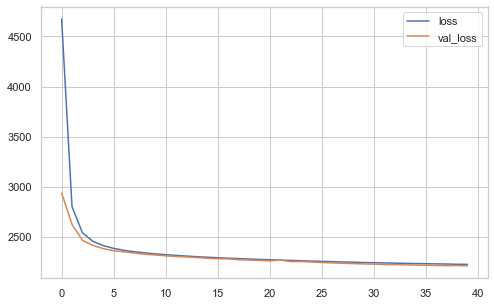

In [133]:
dnn_1_df_hist = pd.DataFrame(history.history)
dnn_1_df_hist = np.sqrt(dnn_1_df_hist)
dnn_1_df_hist.plot(figsize=(8,5))
plt.grid(True)
plt.show()

In [134]:
mse_dnn = dnn.evaluate(autos_features_prepared_m1_tr, autos_label_m1_tr)
rmse_dnn = np.sqrt(mse_dnn)
print(rmse_dnn)

246885/246885 [==============================] - 6s 26us/sample - loss: 4918781.7720
2217.8326744754113


In [135]:
X_new = autos_features_prepared_m1_tr[:5]
y_pred = dnn.predict(X_new)
print(y_pred)
print(autos_label_m1_tr[:5])

[[ 5566.796 ]
 [ 4877.4585]
 [10483.691 ]
 [24396.086 ]
 [ 1003.2075]]
[ 5349  5000  8750 21600   449]


Of all models tested herein, __Random Forest__ is the one yielding the smallest *rmse*. However, we can see that the score on the training set is still much lower than on the validation set, meaning that the model is overfitting the training set. In the next section we will aim to optimize our hyperparameters for better results. In addition, we will also attempt to improve the performance of our __Neural Network__, which also displayed a good performance.

### Business Model 2

### Linear Regression

In [137]:
SL = 0.05
X_opt_2 = autos_features_prepared_m2_tr
autos_opt_2 = backwardElimination_p(autos_label_m2_tr, X_opt_2, SL)

In [138]:
autos_opt_2 = np.append(arr = np.ones((X_opt_2.shape[0],1)).astype(int), values = autos_opt_2, axis=1)

In [139]:
OLS_lin_reg_2 = sm.OLS(autos_label_m2_tr, autos_opt_2).fit()

In [140]:
print(OLS_lin_reg_2.summary())

                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.031
Model:                            OLS   Adj. R-squared:                  0.030
Method:                 Least Squares   F-statistic:                     71.10
Date:                Thu, 04 Jun 2020   Prob (F-statistic):               0.00
Time:                        13:40:22   Log-Likelihood:            -8.6726e+05
No. Observations:              246885   AIC:                         1.735e+06
Df Residuals:                  246774   BIC:                         1.736e+06
Df Model:                         110                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          4.4471      0.028    159.904      0.0

In [141]:
OLS_pred_2 = OLS_lin_reg_2.predict(autos_opt_2)
OLS_lin_mse_2 = mean_squared_error(autos_label_m2_tr, OLS_pred_2)
OLS_lin_rmse_2 = np.sqrt(OLS_lin_mse_2)
OLS_lin_rmse_2.round(2)

8.12

In [142]:
OLS_lin_reg_scores_2 = cross_val_score(SMWrapper(sm.OLS), autos_opt_2, autos_label_m2_tr, 
                                 scoring="neg_mean_squared_error", cv=10)
OLS_lin_reg_rmse_scores_2 = np.sqrt(-OLS_lin_reg_scores_2)
display_scores(OLS_lin_reg_rmse_scores_2)

Scores:  [8.12 8.15 8.15 8.11 8.11 8.09 8.08 8.14 8.1  8.16]
Mean: 8.12
Standard deviation: 0.03


### Decision Tree

In [143]:
tree_2 = DecisionTreeRegressor(random_state=24)
tree_2.fit(autos_features_prepared_m2_tr, autos_label_m2_tr)

DecisionTreeRegressor(ccp_alpha=0.0, criterion='mse', max_depth=None,
                      max_features=None, max_leaf_nodes=None,
                      min_impurity_decrease=0.0, min_impurity_split=None,
                      min_samples_leaf=1, min_samples_split=2,
                      min_weight_fraction_leaf=0.0, presort='deprecated',
                      random_state=24, splitter='best')

In [144]:
predictions_2 = tree_2.predict(autos_features_prepared_m2_tr)
tree_mse_2 = mean_squared_error(autos_label_m2_tr, predictions_2)
tree_rmse_2 = np.sqrt(tree_mse_2)
print('%5.4f'%tree_rmse_2)

2.3211


In [145]:
scores_2 = cross_val_score(tree_2, autos_features_prepared_m2_tr, autos_label_m2_tr,
                         scoring="neg_mean_squared_error", cv=10)
tree_rmse_scores_2 = np.sqrt(-scores_2)

In [146]:
display_scores(tree_rmse_scores_2)

Scores:  [10.82 10.69 10.8  10.79 10.8  10.72 10.74 10.78 10.78 10.73]
Mean:10.76
Standard deviation: 0.04


### Random Forest

In [147]:
forest_2 = RandomForestRegressor(random_state=24, n_estimators=10) #n_estimators = number of trees
forest_2.fit(autos_features_prepared_m2_tr, autos_label_m2_tr)

RandomForestRegressor(bootstrap=True, ccp_alpha=0.0, criterion='mse',
                      max_depth=None, max_features='auto', max_leaf_nodes=None,
                      max_samples=None, min_impurity_decrease=0.0,
                      min_impurity_split=None, min_samples_leaf=1,
                      min_samples_split=2, min_weight_fraction_leaf=0.0,
                      n_estimators=10, n_jobs=None, oob_score=False,
                      random_state=24, verbose=0, warm_start=False)

In [148]:
predictions_2 = forest_2.predict(autos_features_prepared_m2_tr)
forest_mse_2 = mean_squared_error(autos_label_m2_tr, predictions_2)
forest_rmse_2 = np.sqrt(forest_mse_2)
print("rmse = ", '%5.4f'%forest_rmse_2)

some_data = autos_features_m2_tr.iloc[:10]
some_labels = autos_label_m2_tr[:10]
some_data_prepared = full_pipeline_2.transform(some_data)
print("Predictions: ", forest_2.predict(some_data_prepared).round(2))
print("Labels: ", list(some_labels.round(2)))

rmse =  4.0324
Predictions:  [ 4.64 10.54 26.24  3.94  6.08  2.97 15.4   5.65 27.65 17.77]
Labels:  [4.07, 9.37, 31.93, 2.8, 2.97, 3.6, 23.43, 5.59, 31.85, 21.85]


In [149]:
forest_scores_2 = cross_val_score(forest_2, autos_features_prepared_m2_tr, autos_label_m2_tr,
                                scoring="neg_mean_squared_error", cv=10)
forest_rmse_scores_2 = np.sqrt(-forest_scores_2)
display_scores(forest_rmse_scores_2)

Scores:  [8.57 8.52 8.62 8.54 8.55 8.52 8.45 8.55 8.54 8.54]
Mean: 8.54
Standard deviation: 0.04


### Regression Deep Neural Network (MLP)

In [150]:
X_train_2, X_valid_2, y_train_2, y_valid_2 = train_test_split(autos_features_prepared_m2_tr, autos_label_m2_tr,
                                                     test_size = 0.2, random_state=24)

In [151]:
print(X_train_2.shape)
print(X_valid_2.shape)
print(y_train_2.shape)
print(y_valid_2.shape)

(197508, 310)
(49377, 310)
(197508,)
(49377,)


In [152]:
dnn_2 = keras.models.Sequential([
    keras.layers.Dense(30, activation="relu", input_shape=X_train_2.shape[1:]),
    keras.layers.Dense(1)
])

In [153]:
dnn_opt_2 = keras.optimizers.Adam(lr=0.001, beta_1=0.9, beta_2=0.999)
dnn_2.compile(loss="mean_squared_error", 
            optimizer=dnn_opt_2)

In [154]:
history_2 = dnn_2.fit(X_train_2, y_train_2, epochs=40,
                 validation_data=(X_valid_2, y_valid_2))

Train on 197508 samples, validate on 49377 samples
Epoch 1/40
197508/197508 [==============================] - 15s 78us/sample - loss: 67.4870 - val_loss: 64.9170
Epoch 2/40
197508/197508 [==============================] - 15s 75us/sample - loss: 65.2879 - val_loss: 64.6821
Epoch 3/40
197508/197508 [==============================] - 15s 74us/sample - loss: 65.0739 - val_loss: 64.5379
Epoch 4/40
197508/197508 [==============================] - 15s 77us/sample - loss: 64.9224 - val_loss: 64.4220
Epoch 5/40
197508/197508 [==============================] - 15s 76us/sample - loss: 64.8211 - val_loss: 64.5884
Epoch 6/40
197508/197508 [==============================] - 15s 76us/sample - loss: 64.7486 - val_loss: 64.3900
Epoch 7/40
197508/197508 [==============================] - 15s 78us/sample - loss: 64.6754 - val_loss: 64.4045
Epoch 8/40
197508/197508 [==============================] - 15s 75us/sample - loss: 64.6170 - val_loss: 64.3578
Epoch 9/40
197508/197508 [===========================

In [155]:
mse_dnn_2 = dnn_2.evaluate(autos_features_prepared_m2_tr, autos_label_m2_tr)
rmse_dnn_2 = np.sqrt(mse_dnn_2)
print(rmse_dnn_2)

246885/246885 [==============================] - 5s 21us/sample - loss: 63.7006
7.9812669895262305


In [156]:
X_new_2 = autos_features_prepared_m2_tr[:5]
y_pred_2 = dnn_2.predict(X_new_2)
print(y_pred_2)
print(autos_label_m2_tr[:5])

[[ 8.79522  ]
 [10.310152 ]
 [11.595446 ]
 [11.3228445]
 [ 9.234784 ]]
[ 4.0744213   9.36549769 31.92925926  2.80300926  2.97083333]


Of all models tested herein, __Neural Network__ is the one yielding the smallest *rmse*. Thus, in the next section we will aim to optimize our hyperparameters for better results. 

## 7. FINE-TUNNING OUR MODEL

### Business Model 1

__Fine-Tuning Random Forest:__

In [158]:
#takes long time to run (more than 3 hours)
param_grid = [
    {'n_estimators':[10, 100, 200]}]

forest_opt = RandomForestRegressor()

grid_search = GridSearchCV(forest_opt, param_grid, cv=5, scoring='neg_mean_squared_error', return_train_score=True)

grid_search.fit(autos_features_prepared_m1_tr, autos_label_m1_tr)

GridSearchCV(cv=5, error_score=nan,
             estimator=RandomForestRegressor(bootstrap=True, ccp_alpha=0.0,
                                             criterion='mse', max_depth=None,
                                             max_features='auto',
                                             max_leaf_nodes=None,
                                             max_samples=None,
                                             min_impurity_decrease=0.0,
                                             min_impurity_split=None,
                                             min_samples_leaf=1,
                                             min_samples_split=2,
                                             min_weight_fraction_leaf=0.0,
                                             n_estimators=100, n_jobs=None,
                                             oob_score=False, random_state=None,
                                             verbose=0, warm_start=False),
             iid='deprecated', n_jo

Now let's get the best combination of parameters:

In [159]:
grid_search.best_params_

{'n_estimators': 200}

We cal also get the best estimator directly:

In [160]:
grid_search.best_estimator_

RandomForestRegressor(bootstrap=True, ccp_alpha=0.0, criterion='mse',
                      max_depth=None, max_features='auto', max_leaf_nodes=None,
                      max_samples=None, min_impurity_decrease=0.0,
                      min_impurity_split=None, min_samples_leaf=1,
                      min_samples_split=2, min_weight_fraction_leaf=0.0,
                      n_estimators=200, n_jobs=None, oob_score=False,
                      random_state=None, verbose=0, warm_start=False)

In [161]:
cvres = grid_search.cv_results_
for mean_score, params in zip(cvres["mean_test_score"], cvres["params"]):
    print(np.sqrt(-mean_score), params)

2033.319493956964 {'n_estimators': 10}
1984.23637559276 {'n_estimators': 100}
1978.863817110151 {'n_estimators': 200}


Using the GridSearch results, we can see that the best model is obtained by setting the **n_estimators hyperparameter to 200 and bootstrap to TRUE (default)**. The RSME score for this combination is 1978.86, which is slightly better than the score we got using the first hyperparameter combination (2017.55). With this final step we have fine-tuned our model.

We can often gain good insights on the problem by inspecting the best models. For example, the RandomForestRegressor can indicate the relative importance of each attribute for making accurate predictions __(Géron, 2019)__.

Each element of feature_importances_ corresponds to one feature of X_train (e.g: first element of feature_importances_ refers to the first feature/column of X_train).

The higher the value of an element in feature_importances_, the more important is the feature in X_train.

In [162]:
feature_importances = grid_search.best_estimator_.feature_importances_
feature_importances.round(3)

array([0.53 , 0.297, 0.034, 0.   , 0.001, 0.009, 0.002, 0.002, 0.003,
       0.003, 0.003, 0.004, 0.004, 0.   , 0.   , 0.   , 0.   , 0.   ,
       0.   , 0.001, 0.   , 0.   , 0.   , 0.   , 0.001, 0.   , 0.   ,
       0.   , 0.001, 0.   , 0.   , 0.   , 0.   , 0.   , 0.   , 0.   ,
       0.   , 0.01 , 0.   , 0.   , 0.001, 0.001, 0.001, 0.001, 0.   ,
       0.   , 0.   , 0.   , 0.   , 0.   , 0.   , 0.   , 0.002, 0.   ,
       0.   , 0.   , 0.   , 0.   , 0.   , 0.   , 0.   , 0.   , 0.   ,
       0.   , 0.   , 0.   , 0.   , 0.   , 0.   , 0.   , 0.   , 0.   ,
       0.001, 0.   , 0.   , 0.   , 0.   , 0.   , 0.   , 0.   , 0.   ,
       0.   , 0.   , 0.   , 0.   , 0.   , 0.   , 0.   , 0.   , 0.   ,
       0.   , 0.   , 0.   , 0.   , 0.   , 0.   , 0.   , 0.   , 0.   ,
       0.   , 0.   , 0.   , 0.001, 0.   , 0.   , 0.   , 0.   , 0.   ,
       0.001, 0.   , 0.   , 0.   , 0.   , 0.   , 0.   , 0.   , 0.   ,
       0.   , 0.   , 0.   , 0.   , 0.   , 0.   , 0.002, 0.   , 0.   ,
       0.   , 0.   ,

__Fine-Tuning Neural Network__:

In [173]:
def build_model(n_hidden=1, n_neurons=30, learning_rate=3e-3, input_shape=[X_train.shape[1]]):
    model = keras.models.Sequential()
    model.add(keras.layers.InputLayer(input_shape=input_shape))
    for layer in range (n_hidden):
        model.add(keras.layers.Dense(n_neurons, activation="relu"))
        model.add(keras.layers.Dense(1))
        optimizer = keras.optimizers.Adam(lr=learning_rate, beta_1=0.9, beta_2=0.999)
        model.compile(loss="mean_squared_error", optimizer=optimizer)
    return model

In [174]:
keras_reg = keras.wrappers.scikit_learn.KerasRegressor(build_model)

In [175]:
dnn_1_hp = {
    "n_hidden": [0, 1, 2, 3],
    "n_neurons": np.arange(1, 100),
    "learning_rate": reciprocal(3e-4, 3e-2),
}

In [176]:
rnd_search_cv = RandomizedSearchCV(keras_reg, dnn_1_hp, n_iter=10, cv=3)

In [ ]:
#takes long time to run (more than 5 hours)
rnd_search_cv.fit(X_train, y_train, epochs=40,
                  validation_data=(X_valid, y_valid),
                  callbacks=[keras.callbacks.EarlyStopping(patience=10)])

In [178]:
rnd_search_cv.best_params_

{'learning_rate': 0.020474602965142034, 'n_hidden': 1, 'n_neurons': 81}

In [179]:
#rnd_search_cv.best_params_
#{'learning_rate': 0.020474602965142034, 'n_hidden': 1, 'n_neurons': 81}

dnn_best = keras.models.Sequential([
    keras.layers.Dense(80, activation="relu", input_shape=X_train.shape[1:]),
    keras.layers.Dense(1),
])
dnn_best.compile(loss="mean_squared_error",
                optimizer = keras.optimizers.Adam(lr=0.0204746, beta_1=0.9, beta_2=0.999))
history_best = dnn_best.fit(X_train, y_train, epochs=40,
                 validation_data=(X_valid, y_valid))

Train on 197508 samples, validate on 49377 samples
Epoch 1/40
197508/197508 [==============================] - 18s 90us/sample - loss: 8288323.9762 - val_loss: 5258696.4310
Epoch 2/40
197508/197508 [==============================] - 17s 85us/sample - loss: 5093887.8568 - val_loss: 4897430.4660
Epoch 3/40
197508/197508 [==============================] - 16s 83us/sample - loss: 4881869.3651 - val_loss: 4788767.9984
Epoch 4/40
197508/197508 [==============================] - 16s 83us/sample - loss: 4774353.8529 - val_loss: 4658846.3293
Epoch 5/40
197508/197508 [==============================] - 18s 93us/sample - loss: 4697522.2311 - val_loss: 4630016.4401
Epoch 6/40
197508/197508 [==============================] - 17s 86us/sample - loss: 4640959.5043 - val_loss: 4561279.3775
Epoch 7/40
197508/197508 [==============================] - 17s 85us/sample - loss: 4595610.7053 - val_loss: 4566911.1100
Epoch 8/40
197508/197508 [==============================] - 24s 122us/sample - loss: 4550716.64

In [180]:
mse_best = dnn_best.evaluate(autos_features_prepared_m1_tr, autos_label_m1_tr)
rmse_best = np.sqrt(mse_best)
print("rmse = ", rmse_best.round(2))

246885/246885 [==============================] - 8s 31us/sample - loss: 4116496.2019
rmse =  2028.92


### Business Model 2

__Fine-Tunning Neural Network:__

In [181]:
def build_model(n_hidden=1, n_neurons=30, learning_rate=3e-3, input_shape=[X_train_2.shape[1]]):
    model = keras.models.Sequential()
    model.add(keras.layers.InputLayer(input_shape=input_shape))
    for layer in range (n_hidden):
        model.add(keras.layers.Dense(n_neurons, activation="relu"))
        model.add(keras.layers.Dense(1))
        optimizer = keras.optimizers.Adam(lr=learning_rate, beta_1=0.9, beta_2=0.999)
        model.compile(loss="mean_squared_error", optimizer=optimizer)
    return model

In [182]:
keras_reg_2 = keras.wrappers.scikit_learn.KerasRegressor(build_model)

In [183]:
dnn_2_hp = {
    "n_hidden": [0, 1, 2, 3],
    "n_neurons": np.arange(1, 100),
    "learning_rate": reciprocal(3e-4, 3e-2),
}

In [184]:
rnd_search_cv_2 = RandomizedSearchCV(keras_reg_2, dnn_2_hp, n_iter=10, cv=3)

In [ ]:
#takes long time to run (more than 5 hours)
rnd_search_cv_2.fit(X_train_2, y_train_2, epochs=40,
                  validation_data=(X_valid_2, y_valid_2),
                  callbacks=[keras.callbacks.EarlyStopping(patience=10)])

In [186]:
rnd_search_cv_2.best_params_

{'learning_rate': 0.00037728259635678936, 'n_hidden': 3, 'n_neurons': 89}

With the wrapped Keral model, score will be the opposite of the MSE, because Scikit-Learn wants scores, not losses, thus the higher the better __(Géron, 2019)__.

In [187]:
rnd_search_cv_2.best_score_

-64.92023388311983

In [188]:
#{'learning_rate': 0.00037728259635678936, 'n_hidden': 3, 'n_neurons': 89}
dnn_best_2 = keras.models.Sequential([
    keras.layers.Dense(50, activation="relu", input_shape=X_train_2.shape[1:]),
    keras.layers.Dense(20, activation="relu"),
    keras.layers.Dense(18, activation="relu"),
    keras.layers.Dense(1),
])
dnn_best_2.compile(loss="mean_squared_error",
                optimizer = keras.optimizers.Adam(lr=0.00037728, beta_1=0.9, beta_2=0.999))
history_best_2 = dnn_best_2.fit(X_train_2, y_train_2, epochs=40,
                 validation_data=(X_valid_2, y_valid_2))

Train on 197508 samples, validate on 49377 samples
Epoch 1/40
197508/197508 [==============================] - 20s 99us/sample - loss: 67.6935 - val_loss: 64.8414
Epoch 2/40
197508/197508 [==============================] - 19s 98us/sample - loss: 65.1474 - val_loss: 64.4734
Epoch 3/40
197508/197508 [==============================] - 21s 105us/sample - loss: 64.8290 - val_loss: 64.3708
Epoch 4/40
197508/197508 [==============================] - 25s 126us/sample - loss: 64.5733 - val_loss: 64.3458
Epoch 5/40
197508/197508 [==============================] - 20s 100us/sample - loss: 64.4104 - val_loss: 64.2291
Epoch 6/40
197508/197508 [==============================] - 19s 98us/sample - loss: 64.2771 - val_loss: 64.0830
Epoch 7/40
197508/197508 [==============================] - 18s 92us/sample - loss: 64.1430 - val_loss: 64.1199
Epoch 8/40
197508/197508 [==============================] - 21s 105us/sample - loss: 64.0440 - val_loss: 64.0864
Epoch 9/40
197508/197508 [=======================

In [189]:
mse_best_2 = dnn_best_2.evaluate(autos_features_prepared_m2_tr, autos_label_m2_tr)
rmse_best_2 = np.sqrt(mse_best_2)
print("rmse = ", rmse_best_2.round(2))

246885/246885 [==============================] - 6s 23us/sample - loss: 62.8149
rmse =  7.93


## 8. EVALUATING SYSTEM ON TEST SET

### Business Model 1

__Random Forest__

In [163]:
X_test_prepared = full_pipeline.transform(autos_features_m1_test)
rf_final_model = grid_search.best_estimator_
rf_final_predictions = rf_final_model.predict(X_test_prepared)

In [164]:
final_mse = mean_squared_error(autos_label_m1_test, rf_final_predictions)
final_rmse = np.sqrt(final_mse)
print(final_rmse)

1976.059844908534


In [165]:
confidence = 0.95
rf_squared_errors = (rf_final_predictions - autos_label_m1_test) ** 2
np.sqrt(stats.t.interval(confidence, len(rf_squared_errors) -1,
                        loc=rf_squared_errors.mean(),
                        scale=stats.sem(rf_squared_errors)))

array([1920.27568156, 2030.31187952])

__Neural Network__

In [190]:
mse_best_test = dnn_best.evaluate(full_pipeline.transform(autos_features_m1_test), autos_label_m1_test)
rmse_best_test = np.sqrt(mse_best_test)
print("rmse = ", rmse_best_test.round(2))

61722/61722 [==============================] - 2s 28us/sample - loss: 4386629.0723
rmse =  2094.43


In [191]:
X_new_best = full_pipeline.transform(autos_features_m1_test[:10])
y_pred_best = dnn_best.predict(X_new_best)
print(y_pred_best)
print(autos_label_m1_test[:10])

[[ 9504.815  ]
 [ 7193.0913 ]
 [15787.537  ]
 [ 4416.9595 ]
 [ 5529.3257 ]
 [  349.33655]
 [ 4495.6343 ]
 [ 5345.486  ]
 [ 9704.621  ]
 [ 5369.0864 ]]
[ 6900 10550 16000  3900  4250  1275  4199  6300  9300  5999]


In [192]:
dnn_final_predictions = dnn_best.predict(full_pipeline.transform(autos_features_m1_test))

In [193]:
confidence = 0.95
dnn_squared_errors = (dnn_final_predictions[:,0] - autos_label_m1_test) ** 2
np.sqrt(stats.t.interval(confidence, len(dnn_squared_errors) -1,
                        loc=dnn_squared_errors.mean(),
                        scale=stats.sem(dnn_squared_errors)))

array([2034.77237281, 2152.43107266])

### Business Model 2

__Neural Network__

In [194]:
mse_best_test_2 = dnn_best_2.evaluate(full_pipeline_2.transform(autos_features_m2_test), autos_label_m2_test)
rmse_best_test_2 = np.sqrt(mse_best_test_2)
print("rmse = ", rmse_best_test_2.round(2))

61722/61722 [==============================] - 1s 22us/sample - loss: 65.0186
rmse =  8.06


In [195]:
X_new_best_2 = full_pipeline_2.transform(autos_features_m2_test[:10])
y_pred_best_2 = dnn_best_2.predict(X_new_best_2)
print(y_pred_best_2)
print(autos_label_m2_test[:10])

[[ 4.619112 ]
 [13.730457 ]
 [ 9.784908 ]
 [ 8.600393 ]
 [ 8.7780075]
 [10.498047 ]
 [ 9.241322 ]
 [10.1311   ]
 [ 9.799898 ]
 [ 6.891257 ]]
[ 4.28099537 24.76084491  2.84450231  5.80342593  0.91069444  2.5324537
 11.17847222  1.31939815 13.65828704  6.09474537]


In [196]:
dnn_final_predictions_2 = dnn_best_2.predict(full_pipeline_2.transform(autos_features_m2_test))

In [197]:
confidence = 0.95
dnn_squared_errors_2 = (dnn_final_predictions_2[:,0] - autos_label_m2_test) ** 2
np.sqrt(stats.t.interval(confidence, len(dnn_squared_errors_2) -1,
                        loc=dnn_squared_errors_2.mean(),
                        scale=stats.sem(dnn_squared_errors_2)))

array([8.01446403, 8.11206276])